# Verifying Volunteer Entries to the NYC Trees Census

#### Using NYC Open Data's [2015 Street Tree Census Data Set](https://data.cityofnewyork.us/Environment/2015-Street-Tree-Census-Tree-Data/pi5s-9p35) (click **Export** to download a non-geospatial version of the dataset), I will conduct exploratory data analysis and feature engineering to find the significance of certain variables on the health of NYC street trees. I then create a classification model to gain further insights into which factors play a role in a tree's health.

#### Ultimately, my goal is to determine which features most help my model perform well and what information may be helpful for future censuses and policy in general. In the future, I would like to create a list of volunteer data entries for which the health status does not match that of my model. This list could be used to have professionals double-check the work of volunteers and re-determine a tree's health if necessary.

## Cleaning and exploring the data
- **Import the necessary libraries.**

In [163]:
# dataframe libraries
import pandas as pd
import numpy as np
import geopandas as gpd
import itertools

# visualizations libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style('ticks')

# custom functions and force reloading upon new versions
from functions import *
%load_ext autoreload
%autoreload 2

# ignore sklearn warnings (code from: https://stackoverflow.com/questions/32612180/eliminating-warnings-from-scikit-learn)
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

# statistical tests
from scipy import stats
import statsmodels.api as sm

# modeling libraries
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import BallTree
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

# saving libraries
import pickle
import gzip

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


- **Import the data and take a look.**

In [4]:
trees_initial = pd.read_csv('data/2015StreetTreesCensus_TREES.csv')
trees_initial.head()

,created_at,tree_id,block_id,the_geom,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,...,st_assem,st_senate,nta,nta_name,boro_ct,state,Latitude,longitude,x_sp,y_sp
0,08/27/2015,180683,348711,POINT (-73.84421521958048 40.723091773924274),3,0,OnCurb,Alive,Fair,Acer rubrum,...,28,16,QN17,Forest Hills,4073900,New York,40.723092,-73.844215,1.027431e+06,202756.768749
1,09/03/2015,200540,315986,POINT (-73.81867945834878 40.79411066708779),21,0,OnCurb,Alive,Fair,Quercus palustris,...,27,11,QN49,Whitestone,4097300,New York,40.794111,-73.818679,1.034456e+06,228644.837379
2,09/05/2015,204026,218365,POINT (-73.93660770459083 40.717580740099116),3,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,...,50,18,BK90,East Williamsburg,3044900,New York,40.717581,-73.936608,1.001823e+06,200716.891267
3,09/05/2015,204337,217969,POINT (-73.93445615919741 40.713537494833226),10,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,...,53,18,BK90,East Williamsburg,3044900,New York,40.713537,-73.934456,1.002420e+06,199244.253136
4,08/30/2015,189565,223043,POINT (-73.97597938483258 40.66677775537875),21,0,OnCurb,Alive,Good,Tilia americana,...,44,21,BK37,Park Slope-Gowanus,3016500,New York,40.666778,-73.975979,9.909138e+05,182202.425999


In [5]:
trees_initial.shape

(683788, 42)

In [6]:
trees_initial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683788 entries, 0 to 683787
Data columns (total 42 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   created_at  683788 non-null  object 
 1   tree_id     683788 non-null  int64  
 2   block_id    683788 non-null  int64  
 3   the_geom    683788 non-null  object 
 4   tree_dbh    683788 non-null  int64  
 5   stump_diam  683788 non-null  int64  
 6   curb_loc    683788 non-null  object 
 7   status      683788 non-null  object 
 8   health      652172 non-null  object 
 9   spc_latin   652169 non-null  object 
 10  spc_common  652169 non-null  object 
 11  steward     652173 non-null  object 
 12  guards      652172 non-null  object 
 13  sidewalk    652172 non-null  object 
 14  user_type   683788 non-null  object 
 15  problems    652124 non-null  object 
 16  root_stone  683788 non-null  object 
 17  root_grate  683788 non-null  object 
 18  root_other  683788 non-null  object 
 19  tr

In [7]:
# look at the numerical data
trees_initial.describe()

,tree_id,block_id,tree_dbh,stump_diam,zipcode,cb_num,borocode,cncldist,st_assem,st_senate,boro_ct,Latitude,longitude,x_sp,y_sp
count,683788.000000,683788.000000,683788.000000,683788.000000,683788.000000,683788.000000,683788.000000,683788.000000,683788.000000,683788.000000,6.837880e+05,683788.000000,683788.000000,6.837880e+05,683788.000000
mean,365205.011085,313793.096236,11.279787,0.432463,10916.246044,343.505404,3.358500,29.943181,50.791583,20.615781,3.404914e+06,40.701261,-73.924060,1.005280e+06,194798.424624
std,208122.092902,114839.024312,8.723042,3.290241,651.553364,115.740601,1.166746,14.328531,18.966520,7.390844,1.175863e+06,0.090311,0.123583,3.428505e+04,32902.061114
min,3.000000,100002.000000,0.000000,0.000000,83.000000,101.000000,1.000000,1.000000,23.000000,10.000000,1.000201e+06,40.498466,-74.254965,9.133493e+05,120973.792223
25%,186582.750000,221556.000000,4.000000,0.000000,10451.000000,302.000000,3.000000,19.000000,33.000000,14.000000,3.011700e+06,40.631928,-73.980500,9.896578e+05,169515.153719
50%,366214.500000,319967.000000,9.000000,0.000000,11214.000000,402.000000,4.000000,30.000000,52.000000,21.000000,4.008100e+06,40.700612,-73.912911,1.008386e+06,194560.252497
75%,546170.250000,404624.000000,16.000000,0.000000,11365.000000,412.000000,4.000000,43.000000,64.000000,25.000000,4.103202e+06,40.762228,-73.834910,1.029991e+06,217019.571916
max,722694.000000,999999.000000,450.000000,140.000000,11697.000000,503.000000,5.000000,51.000000,87.000000,36.000000,5.032300e+06,40.912918,-73.700488,1.067248e+06,271894.092088


- **Rename some columns.**

In [8]:
trees_initial.columns = ['created_at', 'tree_id', 'block_id', 'the_geom', 'tree_dbh',
       'stump_diam', 'curb_loc', 'status', 'health', 'spc_latin', 'spc_common',
       'steward', 'guards', 'sidewalk', 'user_type', 'problems', 'root_stone',
       'root_grate', 'root_other', 'trunk_wire', 'trunk_light', 'trunk_other',
       'branch_light', 'branch_shoe', 'branch_other', 'address', 'zipcode',
       'zip_city', 'cb_num', 'borocode', 'boroname', 'council_dist', 'st_assem',
       'st_senate', 'nta', 'nta_name', 'boro_ct', 'state', 'latitude',
       'longitude', 'x_sp', 'y_sp']

- **Remove stumps and dead trees.**

In [9]:
trees_initial.status.value_counts()

Alive    652173
Stump     17654
Dead      13961
Name: status, dtype: int64

In [10]:
# get indices of dead trees and stumps
dead = trees_initial[trees_initial.status.isin(['Dead', 'Stump'])].index
 
# delete rows with these indices from dataFrame
trees_initial.drop(dead, inplace=True)

trees_initial.shape

(652173, 42)

- **Drop some unneccesary columns and set the index to each tree's unique ID.**

In [11]:
drop_cols = ['created_at', 'the_geom', 'stump_diam', 'status', 'spc_latin', 'problems', 'address', 'zipcode',
             'zip_city', 'borocode', 'boro_ct', 'state', 'x_sp', 'y_sp']
trees_initial.drop(columns=drop_cols, inplace=True)
trees_initial.set_index(['tree_id'], inplace=True)
trees_initial.shape

(652173, 27)

- **Look for NaN values.**

In [12]:
trees_initial.isna().sum()

block_id        0
tree_dbh        0
curb_loc        0
health          1
spc_common      5
steward         0
guards          1
sidewalk        1
user_type       0
root_stone      0
root_grate      0
root_other      0
trunk_wire      0
trunk_light     0
trunk_other     0
branch_light    0
branch_shoe     0
branch_other    0
cb_num          0
boroname        0
council_dist    0
st_assem        0
st_senate       0
nta             0
nta_name        0
latitude        0
longitude       0
dtype: int64

- **Drop the few rows with missing values for the target variable and species of tree.**

In [13]:
trees_initial.dropna(how='any', axis=0, inplace=True)

### Save/Load a copy of the cleaned up version

In [16]:
# # uncomment to save
# trees_initial.to_csv('data/nyc_trees_2015_initial_clean.csv')

# uncomment to load
trees = pd.read_csv('data/nyc_trees_2015_initial_clean.csv', index_col=0)

In [17]:
trees.head()

,block_id,tree_dbh,curb_loc,health,spc_common,steward,guards,sidewalk,user_type,root_stone,...,branch_other,cb_num,boroname,council_dist,st_assem,st_senate,nta,nta_name,latitude,longitude
tree_id,,,,,,,,,,,,,,,,,,,,,
180683,348711,3,OnCurb,Fair,red maple,None,None,NoDamage,TreesCount Staff,No,...,No,406,Queens,29,28,16,QN17,Forest Hills,40.723092,-73.844215
200540,315986,21,OnCurb,Fair,pin oak,None,None,Damage,TreesCount Staff,Yes,...,No,407,Queens,19,27,11,QN49,Whitestone,40.794111,-73.818679
204026,218365,3,OnCurb,Good,honeylocust,1or2,None,Damage,Volunteer,No,...,No,301,Brooklyn,34,50,18,BK90,East Williamsburg,40.717581,-73.936608
204337,217969,10,OnCurb,Good,honeylocust,None,None,Damage,Volunteer,Yes,...,No,301,Brooklyn,34,53,18,BK90,East Williamsburg,40.713537,-73.934456
189565,223043,21,OnCurb,Good,American linden,None,None,Damage,Volunteer,Yes,...,No,306,Brooklyn,39,44,21,BK37,Park Slope-Gowanus,40.666778,-73.975979


## Feature engineering and EDA

- **Create and pickle a dictionary of neighborhood codes and names, in case I need to refer back to that later.**

In [18]:
nta = list(trees['nta'].unique())

In [19]:
nta_name = list(trees['nta_name'].unique())

In [20]:
nta_dict = {k: v for k,v in zip(nta, nta_name)}

In [21]:
# # uncomment to save
# with open('data/nta_dict.pickle', 'wb') as f:
#     pickle.dump(nta_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

- **I want to build a model based on the professional entries, so let's drop all of the volunteer entries.**
    - **Before I do that, however, I want to create a variable to see if the amount of trees on a block has any relationship to the health of trees.**
    - **Doing this before dropping volunteers will give me the most accurate block count.**

In [22]:
# get a sense of the values that'll be created
trees.block_id.value_counts().unique()

array([440, 356, 241, 206, 194, 176, 148, 145, 136, 124, 121, 118, 115,
       108, 104, 103, 102,  99,  96,  92,  91,  89,  88,  86,  85,  83,
        80,  78,  77,  76,  75,  74,  72,  71,  70,  69,  68,  67,  65,
        64,  63,  62,  61,  60,  59,  58,  57,  56,  55,  54,  53,  52,
        51,  50,  49,  48,  47,  46,  45,  44,  43,  42,  41,  40,  39,
        38,  37,  36,  35,  34,  33,  32,  31,  30,  29,  28,  27,  26,
        25,  24,  23,  22,  21,  20,  19,  18,  17,  16,  15,  14,  13,
        12,  11,  10,   9,   8,   7,   6,   5,   4,   3,   2,   1])

In [23]:
# create a column with the total count of the trees on that row's block
block_counts = trees.block_id.value_counts().rename('block_count')

# merge onto dataframe
trees = trees.merge(block_counts.to_frame(),
                                left_on='block_id',
                                right_index=True)

# see if it matches list above
trees.block_count.unique()

array([ 15,  21,   4,  24,   5,   3,  14,  11,   7,  13,   8,  20,  12,
        16,  10,   2,   6,   9,  60,  19,  43,  18,  17,  27,   1,  42,
        29,  25,  46,  22,  23,  34,  26,  67,  72,  31, 103,  38,  41,
        49, 104, 440,  37,  32,  63,  28,  36,  69, 194,  53,  47,  35,
        48,  44,  33,  30, 136,  55,  39,  58,  45, 145,  77,  40,  68,
        50,  64,  99,  92,  62,  61,  59,  88, 124,  80,  52,  51,  83,
        74, 148, 241,  56,  75,  54,  57, 176,  70, 206, 356,  86,  78,
        71,  96, 108, 121,  89,  76,  85, 115, 118,  65, 102,  91])

In [24]:
trees.block_count.describe()

count    652173.000000
mean         12.376963
std          18.846380
min           1.000000
25%           5.000000
50%           9.000000
75%          15.000000
max         440.000000
Name: block_count, dtype: float64

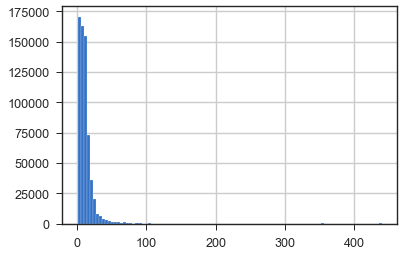

In [25]:
trees.block_count.hist(bins=100)

- **I'll normalize the block count by taking the log value.**

In [26]:
trees['log_block_count'] = trees.block_count.apply(lambda x: np.log(x))

In [27]:
trees.log_block_count.describe()

count    652173.000000
mean          2.178292
std           0.778604
min           0.000000
25%           1.609438
50%           2.197225
75%           2.708050
max           6.086775
Name: log_block_count, dtype: float64

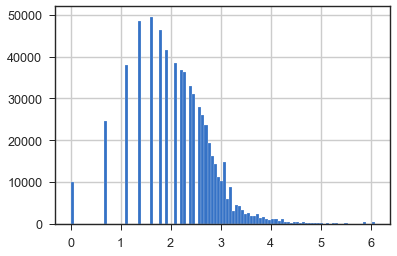

In [28]:
trees.log_block_count.hist(bins=100)

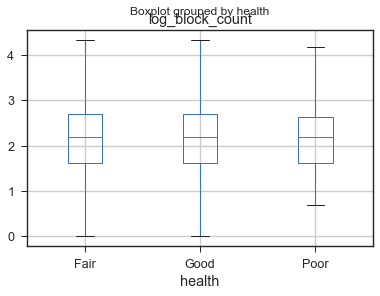

In [29]:
trees.boxplot('log_block_count', 'health', showfliers=False)

- **The new feature doesn't look too promising, but I'll see if reining in extreme values affects this a little later on.**


- **On to dropping those volunteers:**
    - **Notice too that volunteers tend to rate fewer trees as 'Good' and more as 'Fair'. Perhaps a result of lack of training.**
    - **And based on my maps (*see mapmaking notebook*), volunteers tended to not venture into the farther reaches of the city, which may skew their results.**
    - **Furthermore, one may assume a bias for volunteers tracking trees in their neighborhoods.**

In [30]:
trees.user_type.value_counts()

TreesCount Staff    282259
Volunteer           207777
NYC Parks Staff     162137
Name: user_type, dtype: int64

In [31]:
trees.groupby('boroname').user_type.value_counts()

boroname       user_type       
Bronx          TreesCount Staff     45158
               NYC Parks Staff      22924
               Volunteer            12503
Brooklyn       Volunteer            74642
               TreesCount Staff     60595
               NYC Parks Staff      34507
Manhattan      Volunteer            41773
               TreesCount Staff     13715
               NYC Parks Staff       6939
Queens         TreesCount Staff    131920
               Volunteer            73150
               NYC Parks Staff      32904
Staten Island  NYC Parks Staff      64863
               TreesCount Staff     30871
               Volunteer             5709
Name: user_type, dtype: int64

- **Volunteer data also seems very skewed by borough.**
    - **Manhattan especially, followed by Brooklyn.**
    - **Bronx and Staten Island are woefully underserved by volunteers.**
    - **Taking just the professional datapoints should help keep the data more independent.**

In [32]:
trees.groupby('user_type').health.value_counts(normalize=True)

user_type         health
NYC Parks Staff   Good      0.824315
                  Fair      0.131093
                  Poor      0.044592
TreesCount Staff  Good      0.814655
                  Fair      0.148067
                  Poor      0.037278
Volunteer         Good      0.795348
                  Fair      0.161019
                  Poor      0.043633
Name: health, dtype: float64

In [33]:
# get indices of volunteer
volunteers = trees[trees.user_type == 'Volunteer'].index
 
# delete rows with these indices from dataFrame
trees.drop(volunteers, inplace=True)

trees.shape

(444396, 29)

- **I'll go ahead and drop some more unnecessary columns.**
    - **I'll be using latitude and longitude later, but I can drop it for this part of feature engineering.**

In [34]:
trees.columns

Index(['block_id', 'tree_dbh', 'curb_loc', 'health', 'spc_common', 'steward',
       'guards', 'sidewalk', 'user_type', 'root_stone', 'root_grate',
       'root_other', 'trunk_wire', 'trunk_light', 'trunk_other',
       'branch_light', 'branch_shoe', 'branch_other', 'cb_num', 'boroname',
       'council_dist', 'st_assem', 'st_senate', 'nta', 'nta_name', 'latitude',
       'longitude', 'block_count', 'log_block_count'],
      dtype='object')

In [35]:
# drop unnecessary columns
drop_cols = ['block_id', 'user_type', 'nta_name', 'latitude', 'longitude', 'block_count']
trees.drop(columns=drop_cols, inplace=True)

# confirm new shape
trees.shape

(444396, 23)

- **Take a look at the target variable.**

In [36]:
trees.health.value_counts()

Good    363595
Fair     63048
Poor     17752
Name: health, dtype: int64

In [37]:
trees.health.value_counts(normalize=True)

Good    0.818180
Fair    0.141874
Poor    0.039946
Name: health, dtype: float64

- **Since I only have two continuous variables (tree diameter and block count), I'll go ahead and rein in the extreme values on that now.**

In [38]:
trees.tree_dbh.describe()

count    444396.000000
mean         11.908217
std           8.831731
min           0.000000
25%           5.000000
50%          10.000000
75%          17.000000
max         425.000000
Name: tree_dbh, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13164c828>]],
      dtype=object)

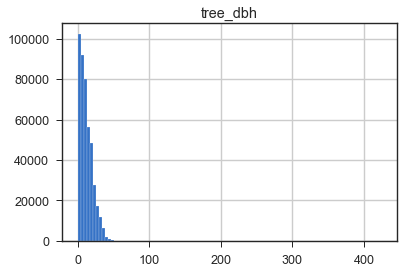

In [39]:
trees.hist('tree_dbh', bins=100)

In [40]:
rein_extremes(trees, ['tree_dbh', 'log_block_count'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12f394240>]],
      dtype=object)

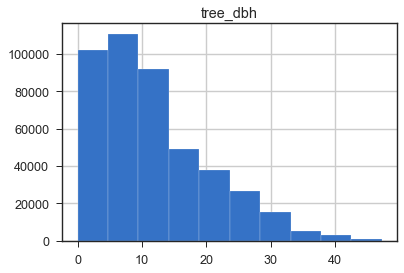

In [41]:
trees.hist('tree_dbh', bins=10)

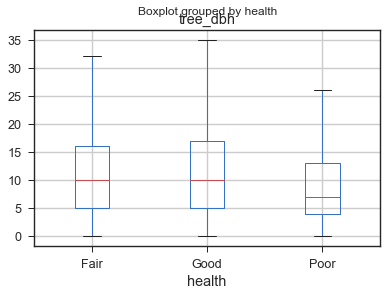

In [42]:
trees.boxplot('tree_dbh', 'health', showfliers=False)

- **Tree diameter looks like a promising feature, as thinner trees tend to be in poor health as compared to thicker trees.**
- **Not much difference between trees in good and fair health, however.**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12f442e80>]],
      dtype=object)

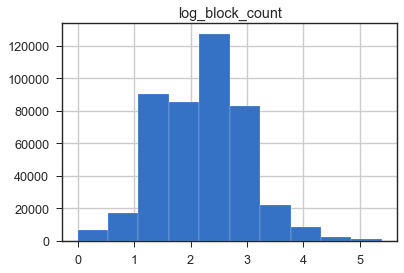

In [43]:
trees.hist('log_block_count', bins=10)

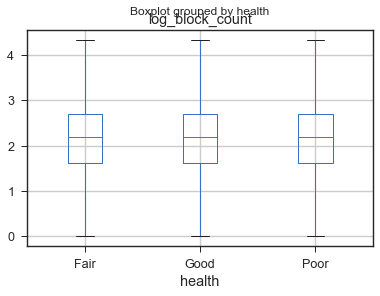

In [44]:
trees.boxplot('log_block_count', 'health', showfliers=False)

- **I'll wait to see if this holds any interactive power in our models.**

### EDA - Boroughs
- **Take a look at the health of trees across the boroughs.**

In [45]:
trees.boroname.value_counts()

Queens           164824
Staten Island     95734
Brooklyn          95102
Bronx             68082
Manhattan         20654
Name: boroname, dtype: int64

In [46]:
trees.groupby('boroname').health.value_counts()

boroname       health
Bronx          Good       57183
               Fair        8409
               Poor        2490
Brooklyn       Good       76922
               Fair       14375
               Poor        3805
Manhattan      Good       16084
               Fair        3420
               Poor        1150
Queens         Good      135192
               Fair       23364
               Poor        6268
Staten Island  Good       78214
               Fair       13480
               Poor        4039
Name: health, dtype: int64

In [47]:
trees.groupby('boroname').health.value_counts(normalize=True)

boroname       health
Bronx          Good      0.839914
               Fair      0.123513
               Poor      0.036574
Brooklyn       Good      0.808837
               Fair      0.151153
               Poor      0.040010
Manhattan      Good      0.778735
               Fair      0.165585
               Poor      0.055679
Queens         Good      0.820220
               Fair      0.141751
               Poor      0.038028
Staten Island  Good      0.817001
               Fair      0.140808
               Poor      0.042190
Name: health, dtype: float64

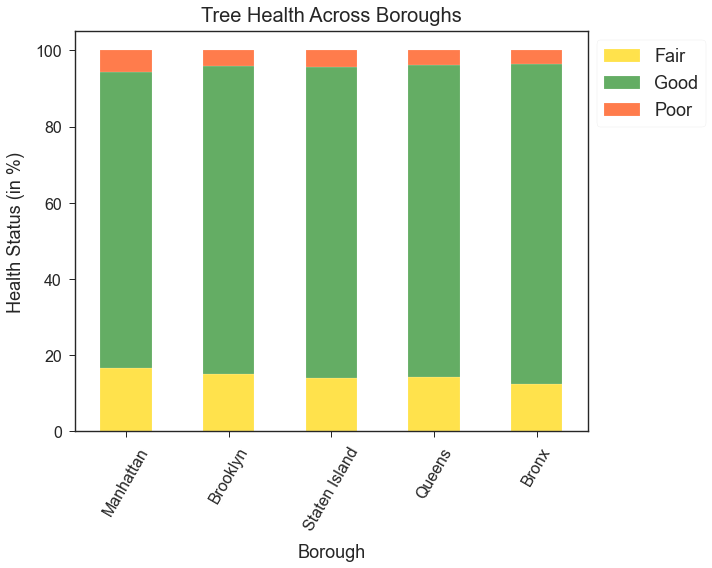

In [49]:
# prepare data for stacked bar, sort by percentage of trees in good health
boros = trees.groupby(['boroname']).health.value_counts(normalize=True).unstack().sort_values('Good')

# plot stacked bar graph
p1 = boros.plot(kind='bar', stacked=True, figsize=(10,8), color=['gold', 'forestgreen', 'orangered'], alpha=0.7)

# prettify the graph
p1.set_title('Tree Health Across Boroughs', fontsize=20, pad=10)
p1.set_xlabel('Borough', fontsize=18, labelpad=10)
p1.set_xticklabels(p1.get_xticklabels(), fontsize=16, rotation=60)
p1.set_ylabel('Health Status (in %)', fontsize=18, labelpad=10)
p1.set_yticklabels([0, 20, 40, 60, 80, 100], fontsize=16)
p1.legend(['Fair','Good', 'Poor'], bbox_to_anchor=(1,1), fontsize=18)

# prepare to save and display
plt.tight_layout()
plt.savefig('charts/health_boro_barstack.png', bbox_inches='tight', transparent=True)
plt.show()

- **There are some slight differences between the boroughs, especially Manhattan from the rest.**
- **I'll do some statistical analyses to see if there's any significance to the differences.**

In [50]:
# create a frequency table
df_boro_health = pd.crosstab(trees.health, trees.boroname)
df_boro_health

boroname,Bronx,Brooklyn,Manhattan,Queens,Staten Island
health,,,,,
Fair,8409,14375,3420,23364,13480
Good,57183,76922,16084,135192,78214
Poor,2490,3805,1150,6268,4039


In [51]:
# returns 𝜒2 value, p-value, degree of freedom and expected values
stat, p, dof, expected = stats.chi2_contingency(df_boro_health)

# p-value shows significance
p

3.726857744054656e-117

In [52]:
# create a table of standardized residuals; anything over +/-1.96 shows significance
table = sm.stats.Table(df_boro_health)
table.standardized_resids

boroname,Bronx,Brooklyn,Manhattan,Queens,Staten Island
health,,,,,
Fair,-14.920895,9.251080,10.001616,-0.179825,-1.066688
Good,15.977821,-8.426026,-15.051387,2.708056,-1.067164
Poor,-4.883631,0.112310,11.823794,-5.013152,4.002333


In [53]:
# percentage of significant values
abs_table = table.standardized_resids.apply(lambda x: abs(x))
print(f'{round((abs_table[abs_table > 1.96].count().sum() / abs_table.count().sum()) * 100, 2)}%')

73.33%


- **Most differences appear to be significant, though not all.**

### EDA - Community Boards

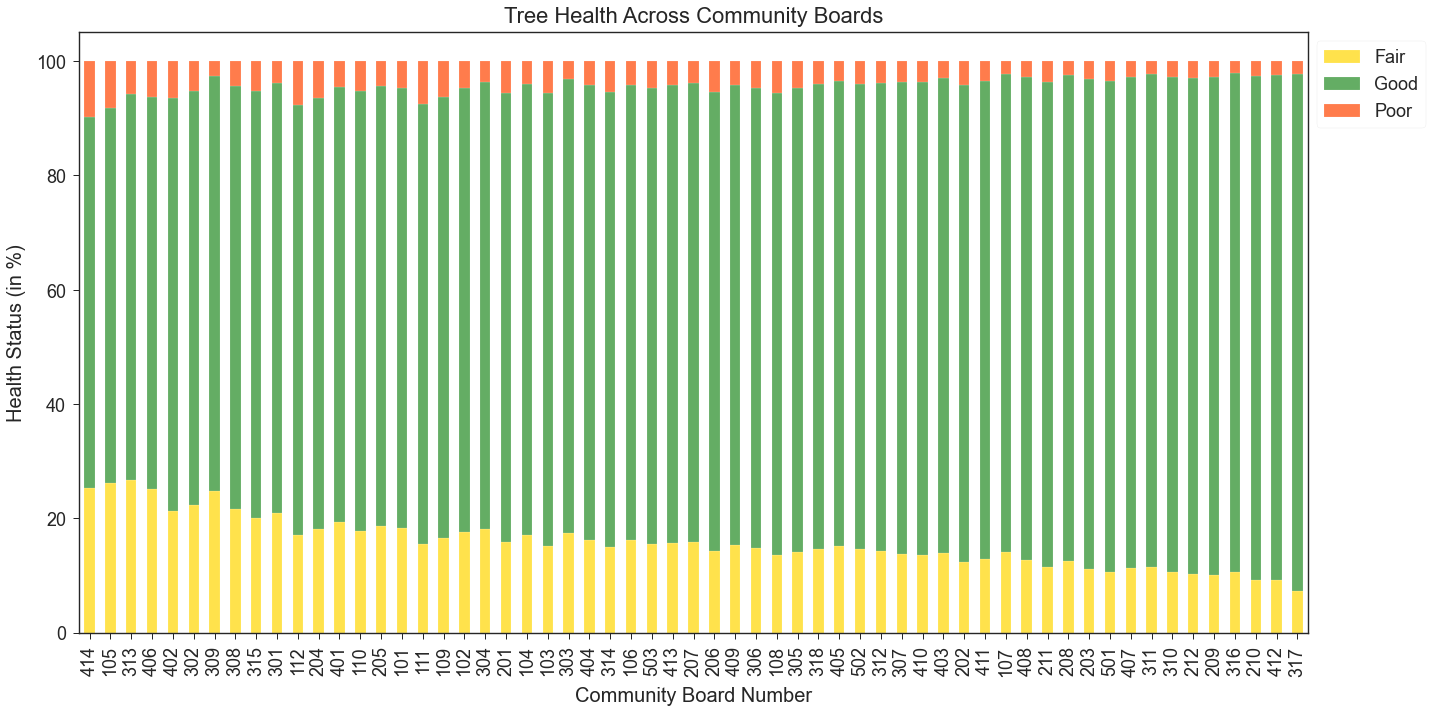

In [54]:
# prepare data for stacked bar, sort by percentage of trees in good health
community_boards = trees.groupby(['cb_num']).health.value_counts(normalize=True).unstack().sort_values('Good')

# plot stacked bar graph
p2 = community_boards.plot(kind='bar', stacked=True, figsize=(20,10),
                   color=['gold', 'forestgreen', 'orangered'], alpha=0.7)

# prettify the graph
p2.set_title('Tree Health Across Community Boards', fontsize=22, pad=10)
p2.set_xlabel('Community Board Number', fontsize=20, labelpad=10)
p2.set_xticklabels(p2.get_xticklabels(), fontsize=18)
p2.set_ylabel('Health Status (in %)', fontsize=20, labelpad=10)
p2.set_yticklabels([0, 20, 40, 60, 80, 100], fontsize=18)
p2.legend(['Fair','Good', 'Poor'], bbox_to_anchor=(1,1), fontsize=18)

# prepare to save and display
plt.tight_layout()
plt.savefig('charts/health_cb_barstack.png', bbox_inches='tight', transparent=True)
plt.show()

- **The differences here seem stronger, at least comparing the left portion of the graph to the right.**
- **Time for more statistical analyses.**

In [55]:
# create a frequency table
df_cb_health = pd.crosstab(trees.health, trees.cb_num)
df_cb_health

cb_num,101,102,103,104,105,106,107,108,109,110,...,408,409,410,411,412,413,414,501,502,503
health,,,,,,,,,,,,,,,,,,,,,
Fair,344,316,232,154,151,198,253,282,296,375,...,1940,1019,1780,2715,2082,4997,2438,2518,3291,7671
Good,1446,1395,1212,710,377,977,1495,1676,1375,1619,...,12952,5344,10898,17499,19767,25522,6231,20231,18306,39677
Poor,89,86,85,36,47,51,40,115,113,111,...,438,278,485,720,541,1314,933,809,910,2320


In [56]:
# returns 𝜒2 value, p-value, degree of freedom and expected values
stat, p, dof, expected = stats.chi2_contingency(df_cb_health)

# test-statistic far greater than critical value
prob = 0.95
critical = stats.chi2.ppf(prob, dof)
critical, stat

(142.13816003902645, 7345.268870343976)

In [57]:
# create a table of standardized residuals; anything over +/-1.96 shows significance
table2 = sm.stats.Table(df_cb_health)
table2.standardized_resids

cb_num,101,102,103,104,105,106,107,108,109,110,...,408,409,410,411,412,413,414,501,502,503
health,,,,,,,,,,,,,,,,,,,,,
Fair,5.129541,4.136041,1.106815,2.516358,8.302737,1.972301,-0.045525,-0.763714,2.916608,4.781010,...,-5.534198,2.721943,-2.218486,-5.174174,-21.513411,8.014518,31.808138,-15.816025,1.918434,8.520068
Good,-5.476037,-4.612929,-2.590174,-2.280597,-10.111061,-1.934446,1.971868,-1.146511,-5.205577,-5.849612,...,8.722733,-2.870020,2.943281,6.814643,25.745913,-7.889588,-43.472408,16.600325,-1.929298,-11.854500
Poor,1.645706,1.715947,3.129344,0.008213,5.120691,0.295825,-3.802504,3.618792,5.055863,3.002452,...,-7.319128,0.802796,-1.844103,-4.202583,-12.375979,1.258998,28.946189,-4.514789,0.381660,8.167192


In [58]:
# percentage of significant values
abs_table2 = table2.standardized_resids.apply(lambda x: abs(x))
print(f'{round((abs_table2[abs_table2 > 1.96].count().sum() / abs_table2.count().sum()) * 100, 2)}%')

75.71%


- **A similar level of significance in health results across the community boards.**

### EDA - Neighborhoods

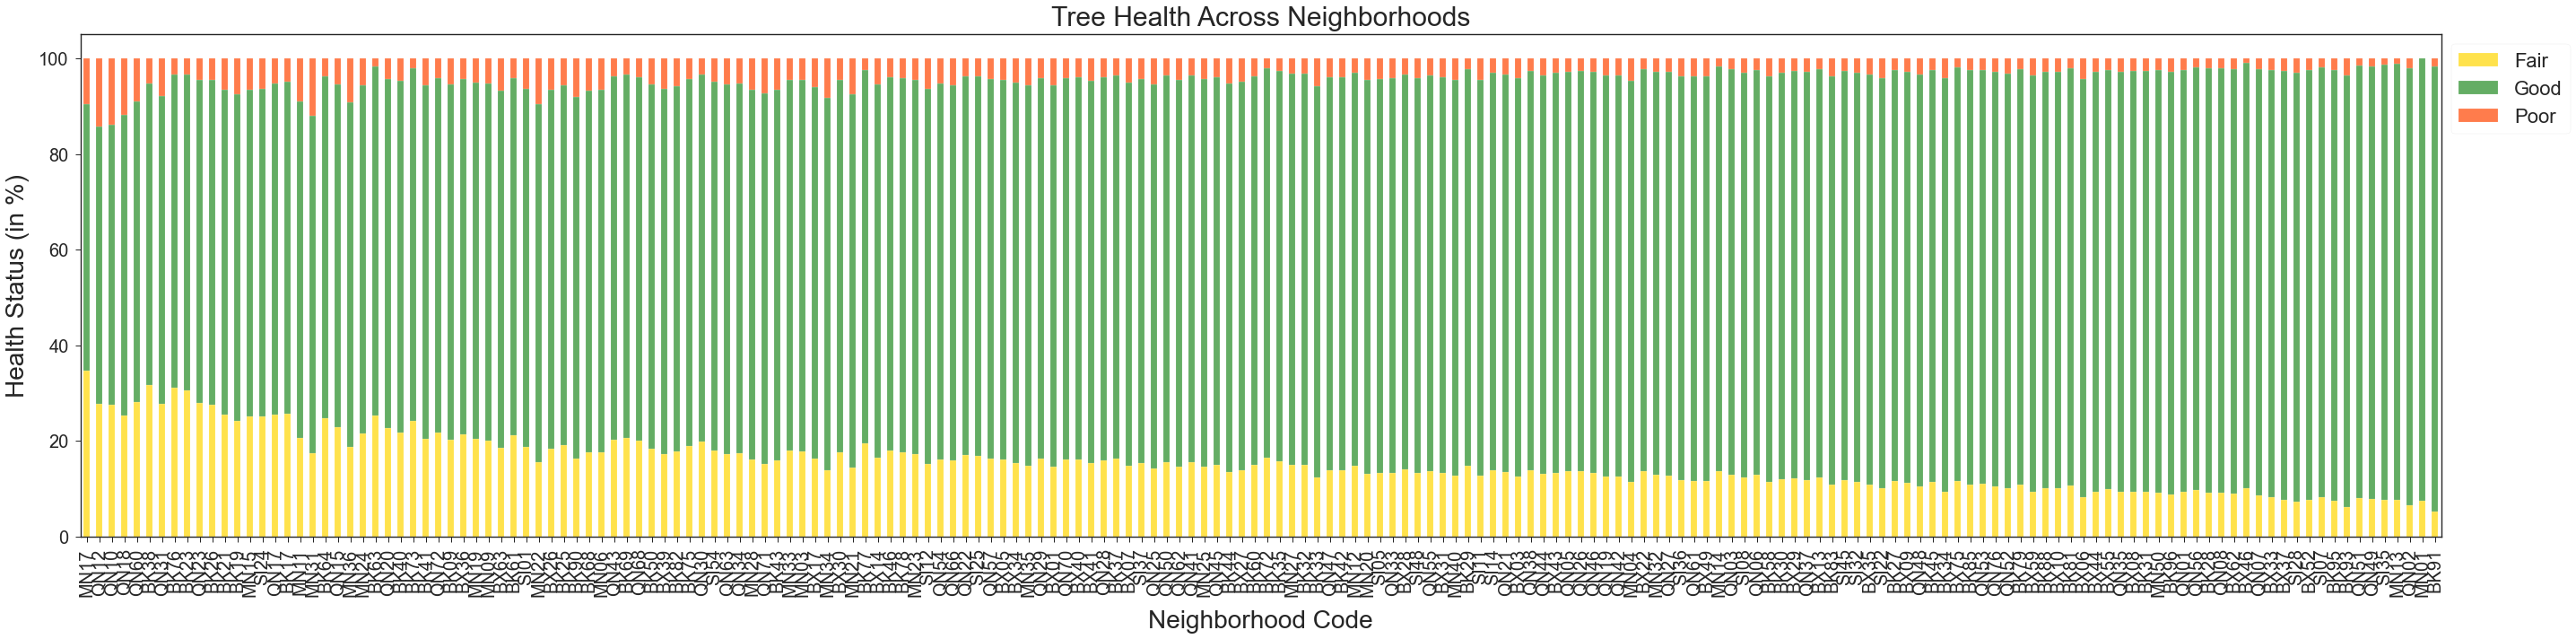

In [59]:
# prepare data for stacked bar, sort by percentage of trees in good health
neighborhoods = trees.groupby(['nta']).health.value_counts(normalize=True).unstack().sort_values('Good')

# plot stacked bar graph
p3 = neighborhoods.plot(kind='bar', stacked=True, figsize=(40,10),
                        color=['gold', 'forestgreen', 'orangered'], alpha=0.7)

# prettify the graph
p3.set_title('Tree Health Across Neighborhoods', fontsize=30, pad=10)
p3.set_xlabel('Neighborhood Code', fontsize=28, labelpad=15)
p3.set_xticklabels(p3.get_xticklabels(), fontsize=20)
p3.set_ylabel('Health Status (in %)', fontsize=28, labelpad=10)
p3.set_yticklabels([0, 20, 40, 60, 80, 100], fontsize=20)
p3.legend(['Fair','Good', 'Poor'], bbox_to_anchor=(1,1), fontsize=22)

# prepare to save and display
plt.tight_layout()
plt.savefig('charts/health_nbhd_barstack.png', bbox_inches='tight', transparent=True)
plt.show()

- **There seems to be a similar difference between the neighborhoods, though these may be too correlated to community board, since each community board is composed of one or a few neighborhoods.**
- **Perform the same statistical analyses.**

In [60]:
# create a frequency table
df_nta_health = pd.crosstab(trees.health, trees.nta)
df_nta_health

nta,BK09,BK17,BK19,BK21,BK23,BK25,BK26,BK27,BK28,BK29,...,SI24,SI25,SI28,SI32,SI35,SI36,SI37,SI45,SI48,SI54
health,,,,,,,,,,,,,,,,,,,,,
Fair,30,1132,182,314,136,675,215,151,187,296,...,959,668,214,1008,238,560,521,519,880,1782
Good,110,3082,514,839,295,2672,529,1116,1809,1655,...,2618,3134,2681,7563,2861,4035,2737,3764,5521,7685
Poor,8,215,57,81,15,197,35,32,41,45,...,241,150,92,271,40,175,148,119,275,482


In [61]:
# returns 𝜒2 value, p-value, degree of freedom and expected values
stat, p, dof, expected = stats.chi2_contingency(df_nta_health)

# test-statistic far greater than critical value
prob = 0.95
critical = stats.chi2.ppf(prob, dof)
critical, stat

(420.09408303637986, 12810.847505114572)

In [62]:
# create a table of standardized residuals; anything over +/-1.96 shows significance
table3 = sm.stats.Table(df_nta_health)
table3.standardized_resids

nta,BK09,BK17,BK19,BK21,BK23,BK25,BK26,BK27,BK28,BK29,...,SI24,SI25,SI28,SI32,SI35,SI36,SI37,SI45,SI48,SI54
health,,,,,,,,,,,,,,,,,,,,,
Fair,2.121231,21.798039,7.857493,11.350354,9.874249,8.323351,10.737936,-2.651359,-6.491742,0.824266,...,19.440401,4.914360,-11.037667,-7.587263,-10.643954,-4.870426,1.862370,-4.581173,-2.373217,10.766831
Good,-2.363987,-21.210262,-9.653883,-12.611368,-8.586768,-9.953299,-10.074888,3.831593,8.197347,1.274655,...,-21.315430,-4.119632,11.285783,9.153618,13.594846,4.992920,-2.217218,6.376965,1.881223,-11.963290
Poor,0.876458,2.935893,5.013552,4.615069,-0.681370,4.773234,0.710640,-2.822367,-4.578275,-3.979013,...,7.343619,-0.642330,-2.561456,-4.509753,-7.810612,-1.155882,1.048610,-4.397108,0.523305,4.378347


In [63]:
# percentage of significant values
abs_table3 = table3.standardized_resids.apply(lambda x: abs(x))
print(f'{round((abs_table3[abs_table3 > 1.96].count().sum() / abs_table3.count().sum()) * 100, 2)}%')

68.97%


- **The percentage of significant values is lower than that of community boards.**
    - **This, plus the fact that residents wanting to make changes to street trees must go through their community board, can be used as an argument for choosing community boards as a feature instead.**
    
- **Since there are so many features that serve as proxies for a tree's location, I'd like to compare their rates of values of significant difference.**

In [64]:
# list of features that contain information about a tree's location in the city 
testers = ['boroname', 'cb_num', 'council_dist', 'nta', 'st_assem', 'st_senate']
for tester in testers:
    
    # create a frequency table
    df_ = pd.crosstab(trees.health, trees[tester])
    
    # create a table of standardized residuals; anything over +/-1.96 shows significance
    table_ = sm.stats.Table(df_)
    
    # percentage of significant values
    abs_table_ = table_.standardized_resids.apply(lambda x: abs(x))
    print(f'{tester}: {round((abs_table_[abs_table_ > 1.96].count().sum() / abs_table_.count().sum()) * 100, 2)}%')

boroname: 73.33%
cb_num: 75.71%
council_dist: 77.78%
nta: 68.97%
st_assem: 77.95%
st_senate: 80.77%


- **Interesting: governmental districts tend to have the highest rates of significantly different values.**
- **Still, when thinking about the data, community board seems like the best choice of location feature, alongside borough.**
    - **New Yorkers very much identify with their borough, and community board is more on the neighborhood level, while holding decently more significantly different values.**
- **For future reference, I'll look at state senate districts, which hold the highest rate of significantly different values.**

### EDA - State Senate Districts

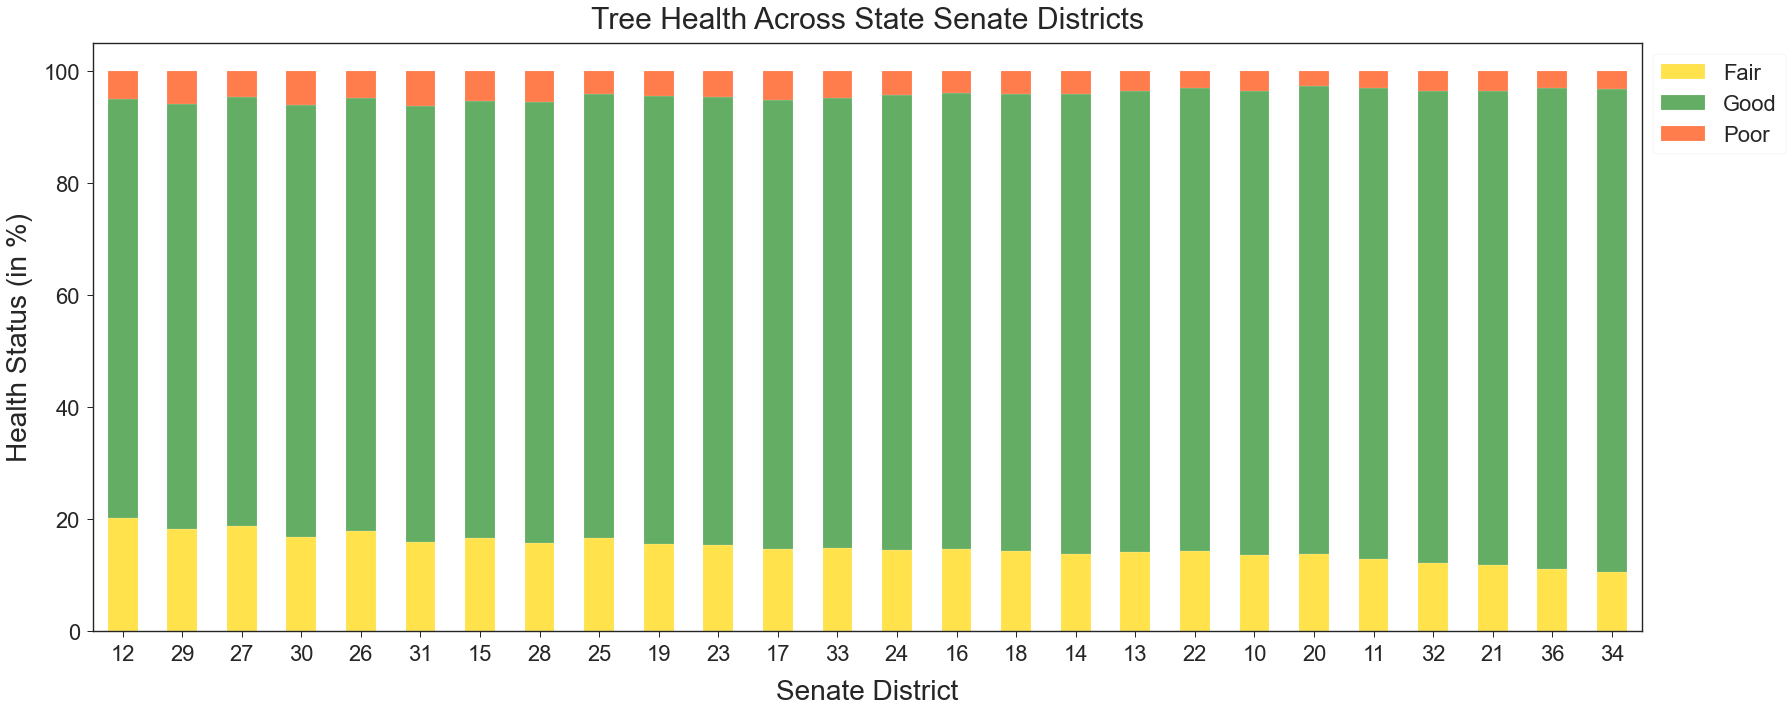

In [65]:
# prepare data for stacked bar, sort by percentage of trees in good health
st_snt = trees.groupby(['st_senate']).health.value_counts(normalize=True).unstack().sort_values('Good')

# plot stacked bar graph
p3b = st_snt.plot(kind='bar', stacked=True, figsize=(25,10), color=['gold', 'forestgreen', 'orangered'], alpha=0.7)

# prettify the graph
p3b.set_title('Tree Health Across State Senate Districts', fontsize=30, pad=15)
p3b.set_xlabel('Senate District', fontsize=28, labelpad=15)
p3b.set_xticklabels(p3b.get_xticklabels(), rotation='horizontal', fontsize=22)
p3b.set_ylabel('Health Status (in %)', fontsize=28, labelpad=10)
p3b.set_yticklabels([0, 20, 40, 60, 80, 100], fontsize=22)
p3b.legend(['Fair','Good', 'Poor'], bbox_to_anchor=(1,1), fontsize=22)

# prepare to save and display
plt.tight_layout()
plt.savefig('charts/health_senate_barstack.png', bbox_inches='tight', transparent=True)
plt.show()

In [66]:
# create a frequency table
df_snt = pd.crosstab(trees.health, trees.st_senate)
df_snt

st_senate,10,11,12,13,14,15,16,17,18,19,...,26,27,28,29,30,31,32,33,34,36
health,,,,,,,,,,,,,,,,,,,,,
Fair,3675,6815,1215,997,4219,4142,2299,1994,1122,3809,...,888,590,482,1358,831,745,1620,1507,2730,1322
Good,22605,44740,4506,5870,25245,19475,12746,10903,6379,19725,...,3857,2426,2433,5673,3821,3657,11258,8208,22610,10218
Poor,957,1611,301,246,1220,1323,610,693,320,1098,...,235,142,170,438,299,289,469,483,806,357


In [67]:
# create a table of standardized residuals; anything over +/-1.96 shows significance
table4 = sm.stats.Table(df_snt)
table4.standardized_resids

st_senate,10,11,12,13,14,15,16,17,18,19,...,26,27,28,29,30,31,32,33,34,36
health,,,,,,,,,,,,,,,,,,,,,
Fair,-3.391458,-9.642157,13.410186,-0.416163,-2.276588,11.276259,1.818190,1.646363,0.405601,5.906635,...,7.411519,7.265907,2.294838,9.977945,5.266752,3.343095,-6.891322,1.727609,-17.894192,-9.744887
Good,5.192559,14.868164,-14.164785,1.558440,2.147214,-15.722426,-1.320748,-4.880560,-0.591101,-7.281836,...,-8.037420,-7.306954,-4.266626,-13.251435,-8.515421,-6.891279,7.696366,-3.527194,20.128924,11.664795
Poor,-4.184174,-12.103391,4.004498,-2.327880,-0.172718,10.874353,-0.638278,6.678961,0.441511,3.817684,...,2.624534,1.445311,4.314409,8.320942,7.387339,7.615994,-2.879669,3.868735,-7.761690,-5.611279


In [68]:
# percentage of significant values
abs_table4 = table4.standardized_resids.apply(lambda x: abs(x))
print(f'{round((abs_table4[abs_table4 > 1.96].count().sum() / abs_table4.count().sum()) * 100, 2)}%')

80.77%


- **One could easily make the argument that this is the location feature to use, but I'll move forward with community board and borough for the reasons outlined above.**

### EDA - Tree species

In [69]:
# species total
print(f'Number of unique species: {len(trees.spc_common.unique())}')

# total trees in current dataset
print(f'Number of total trees: {len(trees)}')

# somewhat arbitrarily assign a value at which I'll lump rarer trees together
print(f'Cutoff for trees of significant quantity (0.1% of total trees): {np.ceil(len(trees)/1000)}')

Number of unique species: 133
Number of total trees: 444396
Cutoff for trees of significant quantity (0.1% of total trees): 445.0


In [70]:
# create a column with the total count of that row's tree species
species_counts = trees['spc_common'].value_counts().rename('species_counts')

# merge onto dataframe
trees = trees.merge(species_counts.to_frame(),
                                left_on='spc_common',
                                right_index=True)

# reassign tree species with fewer than 445 datapoints to 'Other'
trees['spc_common'] = np.where(trees.species_counts < 445, 'Other', trees.spc_common)

# take a look
trees.spc_common.value_counts().head(20)

London planetree     60350
Callery pear         42487
honeylocust          38350
pin oak              35985
Norway maple         25253
cherry               22772
Japanese zelkova     18928
littleleaf linden    18469
red maple            13906
ginkgo               11355
green ash            10573
Sophora              10440
silver maple         10081
Other                 9918
American linden       8399
sweetgum              8380
purple-leaf plum      5281
maple                 5211
American elm          5192
northern red oak      5153
Name: spc_common, dtype: int64

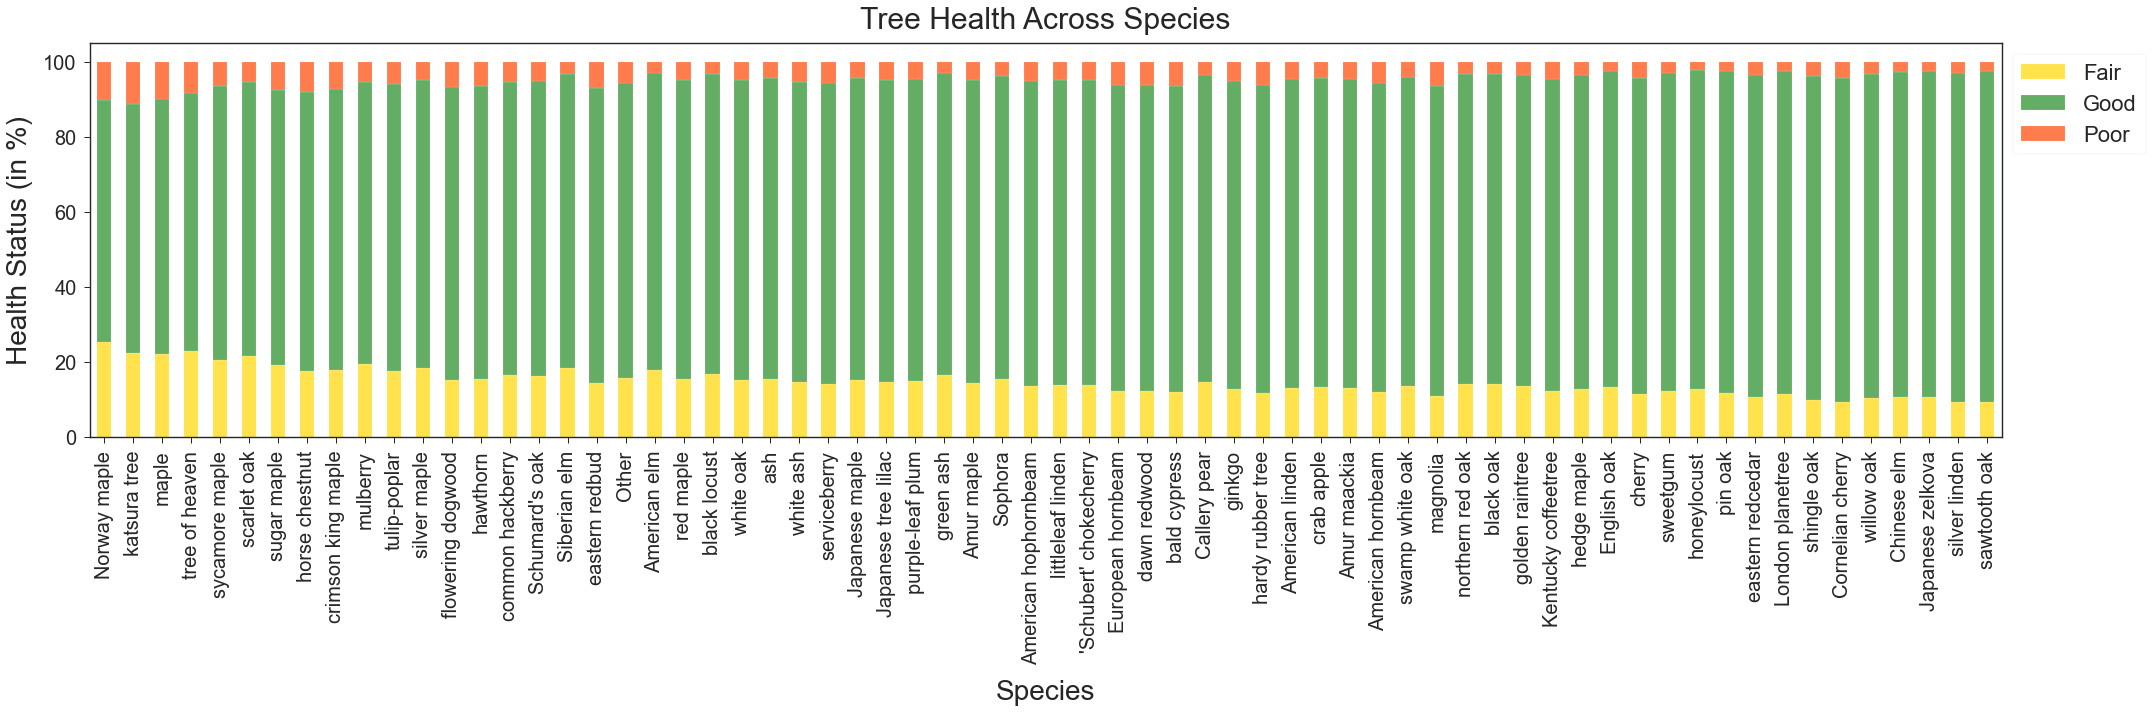

In [71]:
# prepare data for stacked bar, sort by percentage of trees in good health
spc = trees.groupby(['spc_common']).health.value_counts(normalize=True).unstack().sort_values('Good')

# plot stacked bar graph
p4 = spc.plot(kind='bar', stacked=True, figsize=(30,10), color=['gold', 'forestgreen', 'orangered'], alpha=0.7)

# prettify the graph
p4.set_title('Tree Health Across Species', fontsize=30, pad=15)
p4.set_xlabel('Species', fontsize=28, labelpad=15)
p4.set_xticklabels(p4.get_xticklabels(), fontsize=20)
p4.set_ylabel('Health Status (in %)', fontsize=28, labelpad=10)
p4.set_yticklabels([0, 20, 40, 60, 80, 100], fontsize=20)
p4.legend(['Fair','Good', 'Poor'], bbox_to_anchor=(1,1), fontsize=22)

# prepare to save and display
plt.tight_layout()
plt.savefig('charts/health_species_barstack.png', bbox_inches='tight', transparent=True)
plt.show()

- **Some definite differences between the left and right portions of the chart.**
- **Time for more statistical analyses.**

In [72]:
# create a frequency table
df_spc_health = pd.crosstab(trees.health, trees.spc_common)
df_spc_health

spc_common,'Schubert' chokecherry,American elm,American hophornbeam,American hornbeam,American linden,Amur maackia,Amur maple,Callery pear,Chinese elm,Cornelian cherry,...,silver maple,sugar maple,swamp white oak,sweetgum,sycamore maple,tree of heaven,tulip-poplar,white ash,white oak,willow oak
health,,,,,,,,,,,,,,,,,,,,,
Fair,442,926,93,140,1099,225,237,6216,304,65,...,1843,350,568,1017,405,106,129,130,175,210
Good,2606,4110,559,954,6913,1412,1342,34820,2444,608,...,7771,1345,3473,7125,1433,321,560,712,916,1761
Poor,151,156,35,63,387,77,79,1451,77,30,...,467,134,167,238,126,38,43,46,54,65


In [73]:
# returns 𝜒2 value, p-value, degree of freedom and expected values
stat, p, dof, expected = stats.chi2_contingency(df_spc_health)

# test-statistic far greater than critical value
prob = 0.95
critical = stats.chi2.ppf(prob, dof)
critical, stat

(157.60992312288903, 10713.712224675208)

In [74]:
# create a table of standardized residuals; anything over +/-1.96 shows significance
table4 = sm.stats.Table(df_spc_health)
table4.standardized_resids

spc_common,'Schubert' chokecherry,American elm,American hophornbeam,American hornbeam,American linden,Amur maackia,Amur maple,Callery pear,Chinese elm,Cornelian cherry,...,silver maple,sugar maple,swamp white oak,sweetgum,sycamore maple,tree of heaven,tulip-poplar,white ash,white oak,willow oak
health,,,,,,,,,,,,,,,,,,,,,
Fair,-0.603054,7.577068,-0.488943,-2.037409,-2.923834,-1.260528,0.124895,2.750928,-5.236118,-3.757896,...,11.917841,6.077983,-1.287809,-5.433658,8.189613,5.322768,2.666049,0.386527,1.064581,-5.020231
Good,-0.522587,-4.994539,-0.305887,0.562140,1.173971,0.604801,-0.927750,0.766746,6.490924,3.211804,...,-12.461606,-9.200652,1.208664,7.681591,-10.196742,-7.152143,-3.731616,-1.266696,-1.597060,5.481894
Poor,2.103768,-3.663568,1.473645,2.523027,2.897396,1.054781,1.604719,-6.411666,-3.454677,0.369879,...,3.308971,7.291624,-0.085951,-5.447788,5.491040,4.602592,2.599336,1.806125,1.248659,-1.851999


In [75]:
# percentage of significant values
abs_table4 = table4.standardized_resids.apply(lambda x: abs(x))
print(f'{round((abs_table4[abs_table4 > 1.96].count().sum() / abs_table4.count().sum()) * 100, 2)}%')

62.12%


- **Pretty low as compared to the location features, but seems important enough to include.**

In [76]:
# drop no longer necessary counts column
trees.drop(columns='species_counts', axis=1, inplace=True)

In [77]:
# uncomment to save
# trees.to_csv('data/nyc_trees_2015_pre_dummies.csv')

### GeoPandas feature engineering
- **I want to see if the distance between trees has any bearing on health.**
    - **To do this, I'll have reimport the initial dataframe and use all the datapoints.**

In [78]:
# load initial dataframe
trees_for_geo = pd.read_csv('data/nyc_trees_2015_initial_clean.csv', index_col=0)
trees_for_geo.head()

,block_id,tree_dbh,curb_loc,health,spc_common,steward,guards,sidewalk,user_type,root_stone,...,branch_other,cb_num,boroname,council_dist,st_assem,st_senate,nta,nta_name,latitude,longitude
tree_id,,,,,,,,,,,,,,,,,,,,,
180683,348711,3,OnCurb,Fair,red maple,None,None,NoDamage,TreesCount Staff,No,...,No,406,Queens,29,28,16,QN17,Forest Hills,40.723092,-73.844215
200540,315986,21,OnCurb,Fair,pin oak,None,None,Damage,TreesCount Staff,Yes,...,No,407,Queens,19,27,11,QN49,Whitestone,40.794111,-73.818679
204026,218365,3,OnCurb,Good,honeylocust,1or2,None,Damage,Volunteer,No,...,No,301,Brooklyn,34,50,18,BK90,East Williamsburg,40.717581,-73.936608
204337,217969,10,OnCurb,Good,honeylocust,None,None,Damage,Volunteer,Yes,...,No,301,Brooklyn,34,53,18,BK90,East Williamsburg,40.713537,-73.934456
189565,223043,21,OnCurb,Good,American linden,None,None,Damage,Volunteer,Yes,...,No,306,Brooklyn,39,44,21,BK37,Park Slope-Gowanus,40.666778,-73.975979


In [79]:
# create geodataframe
trees_gdf = gpd.GeoDataFrame(trees_for_geo[['health', 'latitude', 'longitude']],
                             geometry=gpd.points_from_xy(trees_for_geo.longitude, trees_for_geo.latitude))

# reset index to sequential numbers
trees_gdf.reset_index(inplace=True)
trees_gdf.head()

,tree_id,health,latitude,longitude,geometry
0,180683,Fair,40.723092,-73.844215,POINT (-73.84422 40.72309)
1,200540,Fair,40.794111,-73.818679,POINT (-73.81868 40.79411)
2,204026,Good,40.717581,-73.936608,POINT (-73.93661 40.71758)
3,204337,Good,40.713537,-73.934456,POINT (-73.93446 40.71354)
4,189565,Good,40.666778,-73.975979,POINT (-73.97598 40.66678)


In [80]:
# Find closest tree and return a dataframe with a new distance column
closest_trees = nearest_neighbor(trees_gdf, return_dist=True)

closest_trees.head()

,tree_id,health,latitude,longitude,geometry,distance
0,236470,Good,40.723001,-73.844173,POINT (-73.84417 40.72300),5.507949
1,200541,Good,40.794090,-73.818770,POINT (-73.81877 40.79409),10.087328
2,204025,Good,40.717634,-73.936631,POINT (-73.93663 40.71763),3.098257
3,204336,Good,40.713563,-73.934360,POINT (-73.93436 40.71356),10.693152
4,218654,Good,40.666648,-73.975948,POINT (-73.97595 40.66665),5.258800


- **I'll look at a boxplot to see if distance from the nearest tree has any discernible impact.**

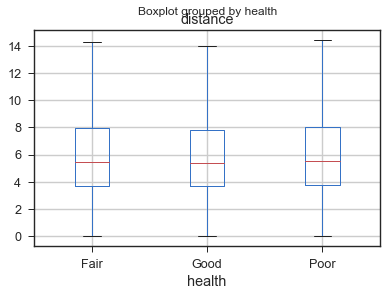

In [81]:
closest_trees.boxplot('distance', 'health', showfliers=False)

- **Alas, the quartiles and medians are almost identical; there are no distinct differences here**
- **Still, I'll add this as a feature to our final model to see if it holds any predictive power there.**

### Dummy columns
- **I have a lot of categorical variables that I need to make dummies for.**
- **As mentioned before, I'll move forward with community board and borough, though one could swap these out for any combination of other area features, though it's important to think about correlation and multicollinearity.**

In [82]:
# I need to merge on 'tree_id', so I won't set that as the index column yet
trees = pd.read_csv('data/nyc_trees_2015_pre_dummies.csv')

In [83]:
# merge 'distance' column from geodataframe
trees = pd.merge(trees, closest_trees[['tree_id', 'distance']], on=['tree_id'], how='inner')

# now we can set the index back to 'tree_id'
trees.set_index(['tree_id'], inplace=True)

# normalize the new values
rein_extremes(trees, ['distance'])

In [84]:
trees.columns

Index(['tree_dbh', 'curb_loc', 'health', 'spc_common', 'steward', 'guards',
       'sidewalk', 'root_stone', 'root_grate', 'root_other', 'trunk_wire',
       'trunk_light', 'trunk_other', 'branch_light', 'branch_shoe',
       'branch_other', 'cb_num', 'boroname', 'council_dist', 'st_assem',
       'st_senate', 'nta', 'log_block_count', 'distance'],
      dtype='object')

- **Convert binary object columns to dummy 0 and 1.**

In [85]:
trees.curb_loc.unique()

array(['OnCurb', 'OffsetFromCurb'], dtype=object)

In [86]:
trees.sidewalk.unique()

array(['Damage', 'NoDamage'], dtype=object)

In [87]:
# rename columns that we have to manually dummy, so the new 0 and 1 values make sense
trees.rename(columns={'curb_loc': 'on_curb', 'sidewalk': 'sidewalk_damage'}, inplace=True)

# trees on curb = 1; trees offset from curb = 0
trees.on_curb = np.where(trees.on_curb == 'OnCurb', 1, 0)
# damage to sidewalk near tree = 1; no sidewalk damage = 0
trees.sidewalk_damage = np.where(trees.sidewalk_damage == 'Damage', 1, 0)

- **Reassign yes-no columns to 1s and 0s.**

In [88]:
trees.branch_other.unique()

array(['No', 'Yes'], dtype=object)

In [89]:
# create list of columns to dummy
yes_no_cols = ['root_stone', 'root_grate', 'root_other', 'trunk_wire', 'trunk_light', 'trunk_other',
               'branch_light', 'branch_shoe', 'branch_other']

# call custom function
yes_to_one(trees, yes_no_cols)
# check to make sure it worked
trees.branch_other.unique()

array([0, 1])

In [90]:
yes_no_cols.extend(['on_curb', 'sidewalk_damage'])

- **Visualize differences in above columns.**

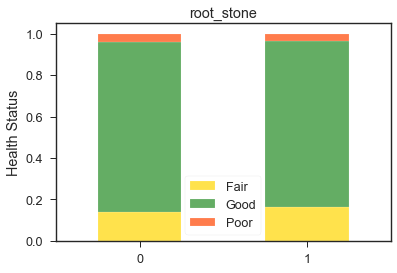

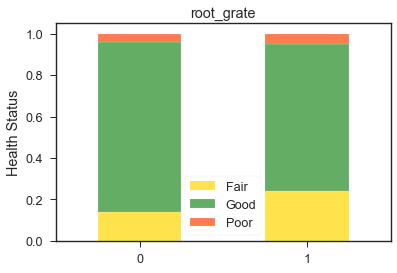

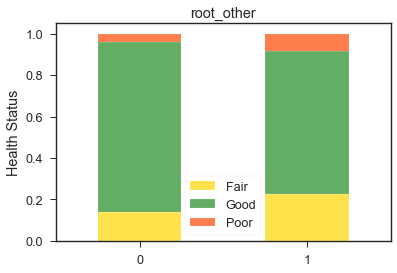

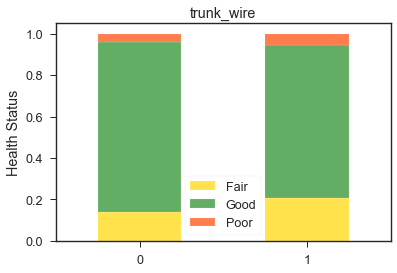

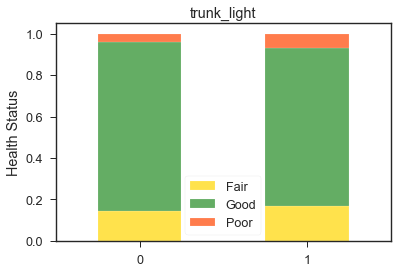

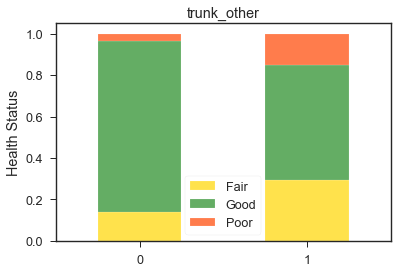

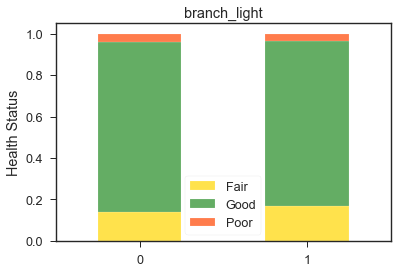

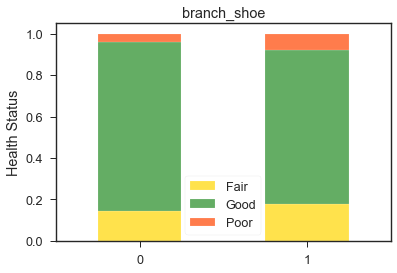

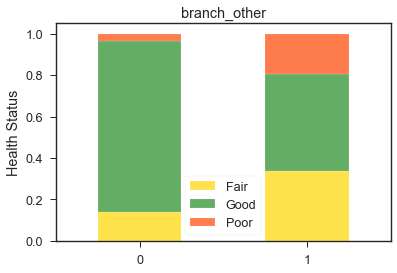

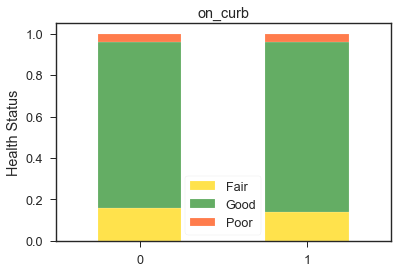

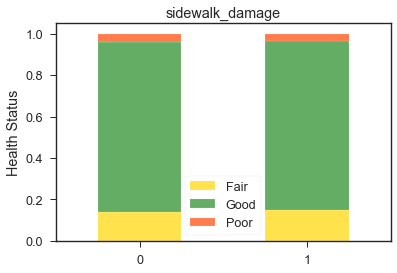

In [95]:
# for loop to visualize the health breakdown of these binary variables
for col in yes_no_cols:
    
    # groupby column and look at health
    grouped = trees.groupby(col).health.value_counts(normalize=True).unstack()
    
    # stacked bar graph
    ax = grouped.plot(kind='bar', stacked=True, color=['gold', 'forestgreen', 'orangered'], alpha=0.7)
    
    # prettify a bit
    ax.set_title(col)
    ax.set_xticklabels([0,1], rotation=0)
    ax.set_xlabel('')
    ax.set_ylabel('Health Status')
    ax.legend(['Fair','Good', 'Poor'])

- **Lots of significant looking variables here.**
- **Some that don't quite pass the "visualization test" are: root_stone, branch_light, on_curb, and sidewalk_damage.**

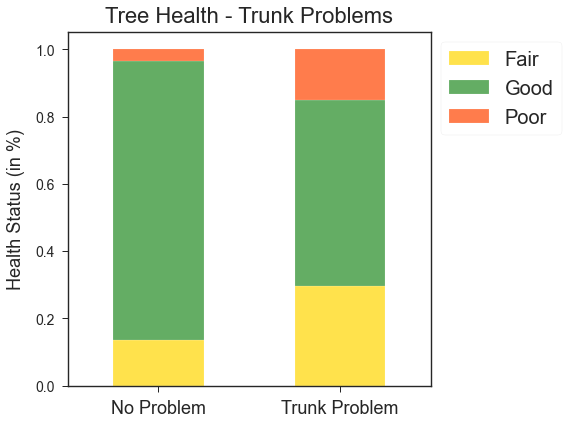

In [98]:
# prepare data for stacked bar, sort by percentage of trees in good health
trunk_o = trees.groupby(['trunk_other']).health.value_counts(normalize=True).unstack().sort_values('Good', ascending=False)

# plot stacked bar graph
p5 = trunk_o.plot(kind='bar', stacked=True, figsize=(8,6), 
                  color=['gold', 'forestgreen', 'orangered'], alpha=0.7, fontsize=14)

# prettify the graph
p5.set_title('Tree Health - Trunk Problems', fontsize=22, pad=10)
p5.set_xlabel('')
p5.set_xticklabels(['No Problem', 'Trunk Problem'], rotation='horizontal', fontsize=18)
p5.set_ylabel('Health Status (in %)', fontsize=18, labelpad=10)
p5.legend(['Fair','Good', 'Poor'], fontsize=20, bbox_to_anchor=(1,1))

# prepare to save and display
plt.tight_layout()
plt.savefig('charts/health_trunk_barstack.png', bbox_inches='tight', transparent=True)
plt.show()

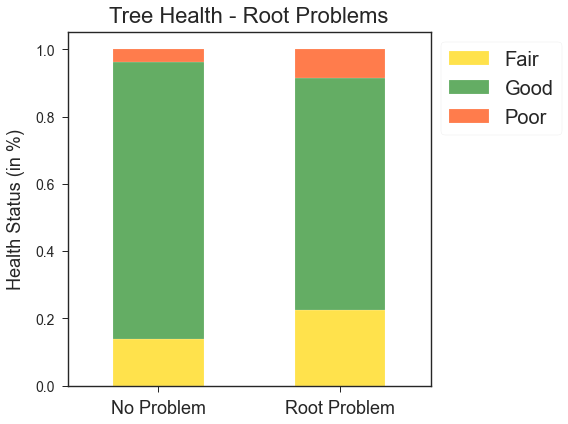

In [99]:
# prepare data for stacked bar, sort by percentage of trees in good health
root_o = trees.groupby(['root_other']).health.value_counts(normalize=True).unstack().sort_values('Good', ascending=False)

# plot stacked bar graph
p6 = root_o.plot(kind='bar', stacked=True, figsize=(8,6), 
                  color=['gold', 'forestgreen', 'orangered'], alpha=0.7, fontsize=14)

# prettify the graph
p6.set_title('Tree Health - Root Problems', fontsize=22, pad=10)
p6.set_xlabel('')
p6.set_xticklabels(['No Problem', 'Root Problem'], rotation='horizontal', fontsize=18)
p6.set_ylabel('Health Status (in %)', fontsize=18, labelpad=10)
p6.legend(['Fair','Good', 'Poor'], fontsize=20, bbox_to_anchor=(1,1))

# prepare to save and display
plt.tight_layout()
plt.savefig('charts/health_root_barstack.png', bbox_inches='tight', transparent=True)
plt.show()

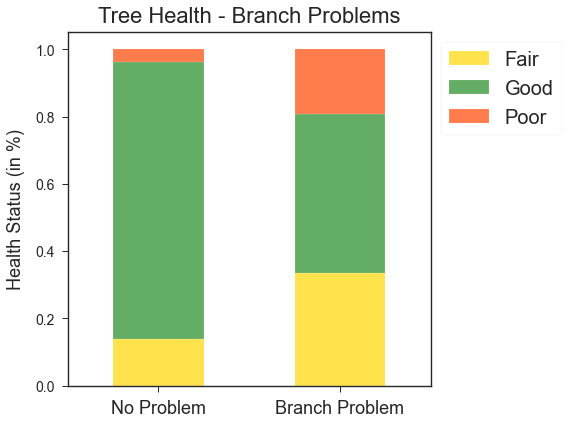

In [100]:
# prepare data for stacked bar, sort by percentage of trees in good health
branch_o = trees.groupby(['branch_other']).health.value_counts(normalize=True).unstack().sort_values('Good', ascending=False)

# plot stacked bar graph
p7 = branch_o.plot(kind='bar', stacked=True, figsize=(8,6),
                   color=['gold', 'forestgreen', 'orangered'], alpha=0.7, fontsize=14)

# prettify the graph
p7.set_title('Tree Health - Branch Problems', fontsize=22, pad=10)
p7.set_xlabel('')
p7.set_xticklabels(['No Problem', 'Branch Problem'], rotation='horizontal', fontsize=18)
p7.set_ylabel('Health Status (in %)', fontsize=18, labelpad=10)
p7.legend(['Fair','Good', 'Poor'], fontsize=20, bbox_to_anchor=(1,1))

# prepare to save and display
plt.tight_layout()
plt.savefig('charts/health_branch_barstack.png', bbox_inches='tight', transparent=True)
plt.show()

- **Dummy variables with more than two values:**
    - **First rename a steward value that doesn't make sense (4 is accounted for twice, so I'm renaming '4orMore' to '5plus').**
    - **Create dummies for number of stewards, usefulness of tree guards, and borough name.**

In [102]:
# rename value
trees['steward'] = np.where(trees.steward == '4orMore', '5plus', trees.steward)

# check
trees.steward.unique()

array(['None', '1or2', '3or4', '5plus'], dtype=object)

In [103]:
# take a look at health values
trees.groupby('steward').health.value_counts(normalize=True)

steward  health
1or2     Good      0.811677
         Fair      0.147157
         Poor      0.041166
3or4     Good      0.826952
         Fair      0.132680
         Poor      0.040368
5plus    Good      0.834770
         Fair      0.129310
         Poor      0.035920
None     Good      0.820114
         Fair      0.140653
         Poor      0.039233
Name: health, dtype: float64

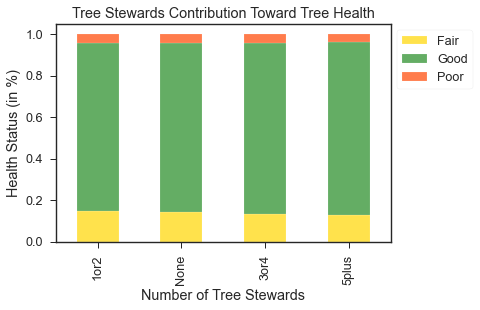

In [104]:
# prepare data for stacked bar, sort by percentage of trees in good health
stewards = trees.groupby(['steward']).health.value_counts(normalize=True).unstack().sort_values('Good')

# plot stacked bar graph
p8 = stewards.plot(kind='bar', stacked=True, 
                   title='Tree Stewards Contribution Toward Tree Health', 
                   color=['gold', 'forestgreen', 'orangered'], alpha=0.7)

# prettify the graph
p8.set_xlabel('Number of Tree Stewards')
p8.set_ylabel('Health Status (in %)')
p8.legend(['Fair','Good', 'Poor'], bbox_to_anchor=(1,1))
plt.show()

- **Health status appears very similar across all values.**

In [111]:
# create a frequency table
df_steward_health = pd.crosstab(trees.health, trees.steward)
df_steward_health

steward,1or2,3or4,5plus,None
health,,,,
Fair,11582,894,90,50431
Good,63883,5572,581,294051
Poor,3240,272,25,14067


In [112]:
# returns 𝜒2 value, p-value, degree of freedom and expected values
stat, p, dof, expected = stats.chi2_contingency(df_steward_health)

# p-value shows significance
p

1.9533006821826916e-06

In [113]:
# create a table of standardized residuals; anything over +/-1.96 shows significance
table = sm.stats.Table(df_steward_health)
table.standardized_resids

steward,1or2,3or4,5plus,None
health,,,,
Fair,4.869989,-2.131341,-0.935484,-3.950735
Good,-5.675904,1.761643,1.098177,4.827035
Poor,2.504345,0.331199,-0.496637,-2.471228


In [114]:
# percentage of significant values
abs_table = table.standardized_resids.apply(lambda x: abs(x))
print(f'{round((abs_table[abs_table > 1.96].count().sum() / abs_table.count().sum()) * 100, 2)}%')

58.33%


- **Almost 50-50, but still something to consider.**
- **What about tree guards?**

In [105]:
# look at breakdown of tree guard quality
trees.guards.value_counts()

None       413265
Helpful     21818
Harmful      6297
Unsure       3308
Name: guards, dtype: int64

In [106]:
# take a look at health values
trees.groupby('guards').health.value_counts(normalize=True)

guards   health
Harmful  Good      0.769255
         Fair      0.181039
         Poor      0.049706
Helpful  Good      0.830507
         Fair      0.129847
         Poor      0.039646
None     Good      0.819273
         Fair      0.141418
         Poor      0.039309
Unsure   Good      0.769649
         Fair      0.175635
         Poor      0.054716
Name: health, dtype: float64

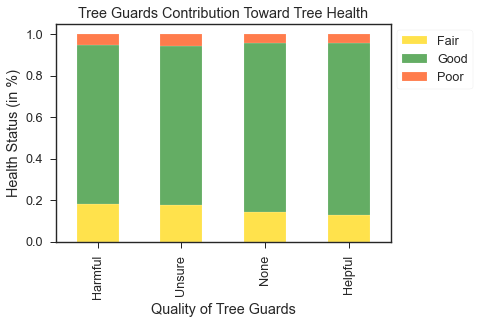

In [108]:
# prepare data for stacked bar, sort by percentage of trees in good health
guards = trees.groupby(['guards']).health.value_counts(normalize=True).unstack().sort_values('Good')

# plot stacked bar graph
p9 = guards.plot(kind='bar', stacked=True, 
                   title='Tree Guards Contribution Toward Tree Health', 
                   color=['gold', 'forestgreen', 'orangered'], alpha=0.7)

# prettify the graph
p9.set_xlabel('Quality of Tree Guards')
p9.set_ylabel('Health Status (in %)')
p9.legend(['Fair','Good', 'Poor'], bbox_to_anchor=(1,1))
plt.show()

- **Health status appears affected by the quality of the tree guards.**

In [115]:
# create a frequency table
df_guards_health = pd.crosstab(trees.health, trees.guards)
df_guards_health

guards,Harmful,Helpful,None,Unsure
health,,,,
Fair,1140,2833,58443,581
Good,4844,18120,338577,2546
Poor,313,865,16245,181


In [116]:
# returns 𝜒2 value, p-value, degree of freedom and expected values
stat, p, dof, expected = stats.chi2_contingency(df_guards_health)

# p-value shows significance
p

1.6585073653792348e-37

In [117]:
# create a table of standardized residuals; anything over +/-1.96 shows significance
table = sm.stats.Table(df_guards_health)
table.standardized_resids

guards,Harmful,Helpful,None,Unsure
health,,,,
Fair,9.024049,-5.133825,-1.719112,5.623790
Good,-10.267868,4.623980,3.303773,-7.357805
Poor,4.147537,0.045722,-3.452725,4.479134


In [118]:
# percentage of significant values
abs_table = table.standardized_resids.apply(lambda x: abs(x))
print(f'{round((abs_table[abs_table > 1.96].count().sum() / abs_table.count().sum()) * 100, 2)}%')

83.33%


- **Definitely some significance here.**

## Vanilla models interruption
- **Now is a good opportunity to look at a starting point for our model.**
- **I'll take a look at a Naive Bayes and a Random Forest.**

In [119]:
# set columns as features that came more or less ready-made, i.e. nothing I engineered or have to fully dummy
prelim_features = ['tree_dbh', 'on_curb', 'sidewalk_damage', 'root_stone', 'root_grate', 'root_other',
                   'trunk_wire', 'trunk_light', 'trunk_other', 'branch_light', 'branch_shoe', 'branch_other']

In [120]:
# create x and y values
X_van = trees[prelim_features]
y_van = trees['health']

In [122]:
# train-test split
X_train_van, X_test_van, y_train_van, y_test_van = train_test_split(X_van, y_van, random_state=42, stratify=y_van)

# use a scaler so we can get the continuous variable on the same scale
scaler = StandardScaler()  
scaler.fit(X_train_van)

# transform x sets
X_train_van = scaler.transform(X_train_van) 
X_test_van = scaler.transform(X_test_van)

### Vanilla Naive Bayes

In [124]:
# create Gaussian Naive Bayes object with prior probabilities of each class--Fair, Good, Poor
van_gnb = GaussianNB(priors=[0.14, 0.82, 0.04])

# train model
van_ganaba = van_gnb.fit(X_train_van, y_train_van)

# predict on test data
van_pred_ganaba = van_ganaba.predict(X_test_van)

# check accuracy
print('Test Accuracy score: ', accuracy_score(y_test_van, van_pred_ganaba))
# check f1
print('Test F1 score: ', f1_score(y_test_van, van_pred_ganaba, average='weighted'))
# check recall
print('Test Recall score: ', recall_score(y_test_van, van_pred_ganaba, average='weighted'))
# check precision
print('Test Precision score: ', precision_score(y_test_van, van_pred_ganaba, average='weighted'))

Test Accuracy score:  0.7817256143633289
Test F1 score:  0.73919894142898
Test Recall score:  0.7817256143633289
Test Precision score:  0.7161070578149361


#### Confusion matrix

Normalized confusion matrix
[[0.04578068 0.86005461 0.09416471]
 [0.02917976 0.93976182 0.03105843]
 [0.03749148 0.8157237  0.14678482]]


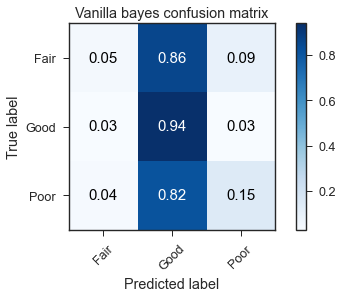

In [125]:
cm_van = confusion_matrix(y_test_van, van_pred_ganaba)
classes = ['Fair', 'Good', 'Poor']

plot_confusion_matrix(cm_van, classes,
                          normalize=True,
                          title='Vanilla bayes confusion matrix',
                          cmap=plt.cm.Blues)

- **Very heavily predicted majority class, as any good baseline model should :P**
### Vanilla Random Forest

In [126]:
# vanilla random forest
van_forest = RandomForestClassifier(class_weight='balanced', random_state=99, n_jobs=-1)

# fit training data
van_forest.fit(X_train_van, y_train_van)

# predict on test data
van_pred_forest = van_forest.predict(X_test_van)

# check accuracy
print('Test Accuracy score: ', accuracy_score(y_test_van, van_pred_forest))
# check f1
print('Test F1 score: ', f1_score(y_test_van, van_pred_forest, average='weighted'))
# check recall
print('Test Recall score: ', recall_score(y_test_van, van_pred_forest, average='weighted'))
# check precision
print('Test Precision score: ', precision_score(y_test_van, van_pred_forest, average='weighted'))

Test Accuracy score:  0.5395963012269276
Test F1 score:  0.6107522411416396
Test Recall score:  0.5395963012269276
Test Precision score:  0.7287054328983223


- **Much worse in terms of accuracy, though the precision is better. Maybe the confusion matrix will tell a more nuanced story.**
#### Confusion matrix

Normalized confusion matrix
[[0.21188647 0.48930091 0.29881262]
 [0.14038364 0.60108545 0.2585309 ]
 [0.16109975 0.39831856 0.44058169]]


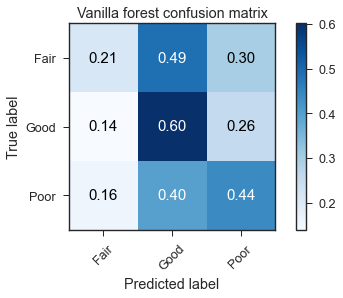

In [127]:
cm_van = confusion_matrix(y_test_van, van_pred_forest)
classes = ['Fair', 'Good', 'Poor']

plot_confusion_matrix(cm_van, classes,
                          normalize=True,
                          title='Vanilla forest confusion matrix',
                          cmap=plt.cm.Blues)

- **Definitely a more even spread of predictions, which is closer to what I'm looking for. Perhaps precision is the most important statistic, though I generally prefer F1 score so I can take both false positives and false negatives into account.**
- **I'll take a look at which features proved important.**

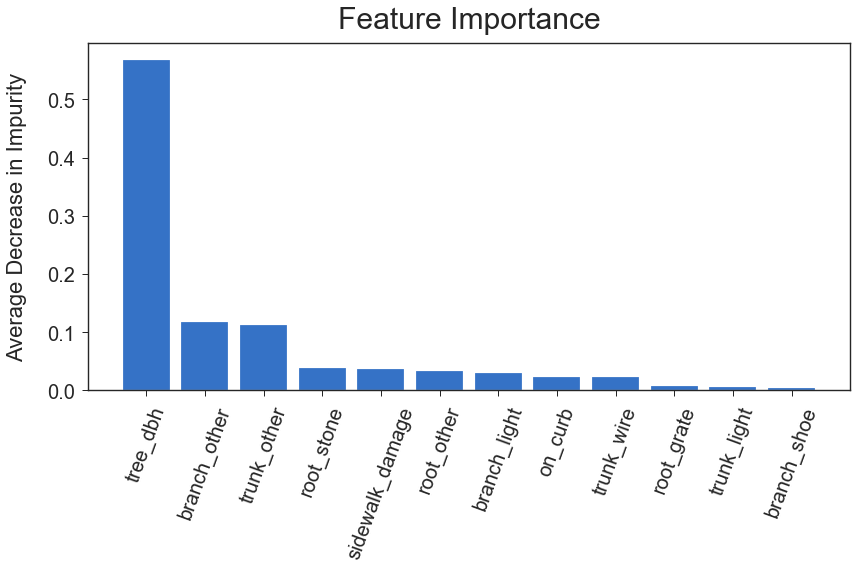

[('tree_dbh', 0.5676255723702696), ('branch_other', 0.11691498562965602), ('trunk_other', 0.11252180175752843), ('root_stone', 0.03782182060377394), ('sidewalk_damage', 0.03653751777400099), ('root_other', 0.03359690795733814), ('branch_light', 0.03055923364768129), ('on_curb', 0.023929543308698682), ('trunk_wire', 0.022820242190424337), ('root_grate', 0.007736559920593996), ('trunk_light', 0.006382472509428248), ('branch_shoe', 0.0035533423306064204)]


In [147]:
plot_forest_features(van_forest, X_van, num_features=X_van.shape[1])

- **Some surprises here:**
    - **Tree diameter topped the list by a large margin.**
    - **Many of the categorical variables hold fairly equal importance.**
- **I'll keep all these in the mix for now and see how they perform in my final model.**

### Finishing up the dummy columns

In [132]:
# choose columns to dummy (again, going ahead with community board as area proxy column)
dummy_cols = ['steward', 'guards', 'boroname', 'cb_num', 'spc_common']

# convert community board column to string so I can easily dummy it
trees['cb_num'] = trees.cb_num.astype(str)

In [133]:
# dummy
tree_dummies = pd.get_dummies(trees[dummy_cols])

# reformat
tree_dummies.columns = [col.replace(' ', '_').replace("'", "") for col in list(tree_dummies.columns)]

# check work
tree_dummies.columns

Index(['steward_1or2', 'steward_3or4', 'steward_5plus', 'steward_None',
       'guards_Harmful', 'guards_Helpful', 'guards_None', 'guards_Unsure',
       'boroname_Bronx', 'boroname_Brooklyn',
       ...
       'spc_common_silver_maple', 'spc_common_sugar_maple',
       'spc_common_swamp_white_oak', 'spc_common_sweetgum',
       'spc_common_sycamore_maple', 'spc_common_tree_of_heaven',
       'spc_common_tulip-poplar', 'spc_common_white_ash',
       'spc_common_white_oak', 'spc_common_willow_oak'],
      dtype='object', length=138)

In [134]:
# add onto the dummy_cols list, so I can drop the pre-dummied columns, plus a dummy from each,
# plus the columns I no longer need
dummy_cols.extend(['steward_None', 'guards_None', 'boroname_Staten_Island', 'cb_num_101', 'spc_common_Other',
                  'council_dist', 'st_assem', 'st_senate', 'nta'])

In [135]:
# combine dataframe and dummy columns
trees_full = pd.concat([trees, tree_dummies], axis=1)

# drop columns
trees_full.drop(columns=dummy_cols, axis=1, inplace=True)

# check
trees_full.columns

Index(['tree_dbh', 'on_curb', 'health', 'sidewalk_damage', 'root_stone',
       'root_grate', 'root_other', 'trunk_wire', 'trunk_light', 'trunk_other',
       ...
       'spc_common_silver_maple', 'spc_common_sugar_maple',
       'spc_common_swamp_white_oak', 'spc_common_sweetgum',
       'spc_common_sycamore_maple', 'spc_common_tree_of_heaven',
       'spc_common_tulip-poplar', 'spc_common_white_ash',
       'spc_common_white_oak', 'spc_common_willow_oak'],
      dtype='object', length=148)

In [136]:
# # uncomment to save
# trees_full.to_csv('data/nyc_trees_final.csv')

# # uncomment to load and check
# trees_full = pd.read_csv('data/nyc_trees_final.csv', index_col=0)
# trees_full.head()

In [137]:
trees_full.head()

,tree_dbh,on_curb,health,sidewalk_damage,root_stone,root_grate,root_other,trunk_wire,trunk_light,trunk_other,...,spc_common_silver_maple,spc_common_sugar_maple,spc_common_swamp_white_oak,spc_common_sweetgum,spc_common_sycamore_maple,spc_common_tree_of_heaven,spc_common_tulip-poplar,spc_common_white_ash,spc_common_white_oak,spc_common_willow_oak
tree_id,,,,,,,,,,,,,,,,,,,,,
200556,10.0,1,Fair,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
205047,10.0,1,Good,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
192941,9.0,1,Good,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
192941,9.0,1,Good,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
192936,17.0,1,Good,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Train-test split and modeling

In [138]:
# create features and target
X = trees_full.drop(columns=['health'], axis=1)
y = trees_full['health']

In [139]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

# use a scaler so we can get the two continuous variables on the same scale
scaler = StandardScaler()  
scaler.fit(X_train)

X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)

In [140]:
from sklearn.tree import DecisionTreeClassifier

In [142]:
# basic random forest
tree = DecisionTreeClassifier(class_weight='balanced', random_state=99)

# fit training data
tree.fit(X_train, y_train)

# predict on test data
y_pred_tree = tree.predict(X_test)

# check accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_tree))
# check f1
print('Test F1 score: ', f1_score(y_test, y_pred_tree, average='weighted'))
# check recall
print('Test Recall score: ', recall_score(y_test, y_pred_tree, average='weighted'))
# check precision
print('Test Precision score: ', precision_score(y_test, y_pred_tree, average='weighted'))

Test Accuracy score:  0.7607940848415069
Test F1 score:  0.7643855778887451
Test Recall score:  0.7607940848415069
Test Precision score:  0.768217781631274


Normalized confusion matrix
[[0.34332339 0.59495841 0.0617182 ]
 [0.11222562 0.85630946 0.03146492]
 [0.20018178 0.52056351 0.27925471]]


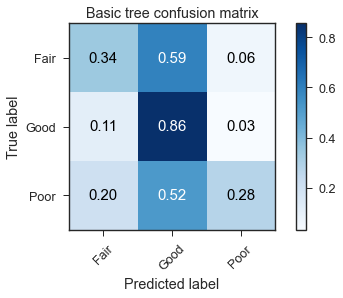

In [143]:
cm_tree = confusion_matrix(y_test, y_pred_tree)
classes = ['Fair', 'Good', 'Poor']

plot_confusion_matrix(cm_tree, classes,
                          normalize=True,
                          title='Basic tree confusion matrix',
                          cmap=plt.cm.Blues)

### Basic random forest

In [148]:
# basic random forest
forest = RandomForestClassifier(class_weight='balanced', random_state=99, n_jobs=-1)

# fit training data
forest.fit(X_train, y_train)

# predict on test data
y_pred_forest = forest.predict(X_test)

# check accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_forest))
# check f1
print('Test F1 score: ', f1_score(y_test, y_pred_forest, average='weighted'))
# check recall
print('Test Recall score: ', recall_score(y_test, y_pred_forest, average='weighted'))
# check precision
print('Test Precision score: ', precision_score(y_test, y_pred_forest, average='weighted'))

Test Accuracy score:  0.8459234339581909
Test F1 score:  0.816783330697617
Test Recall score:  0.8459234339581909
Test Precision score:  0.8219060509792554


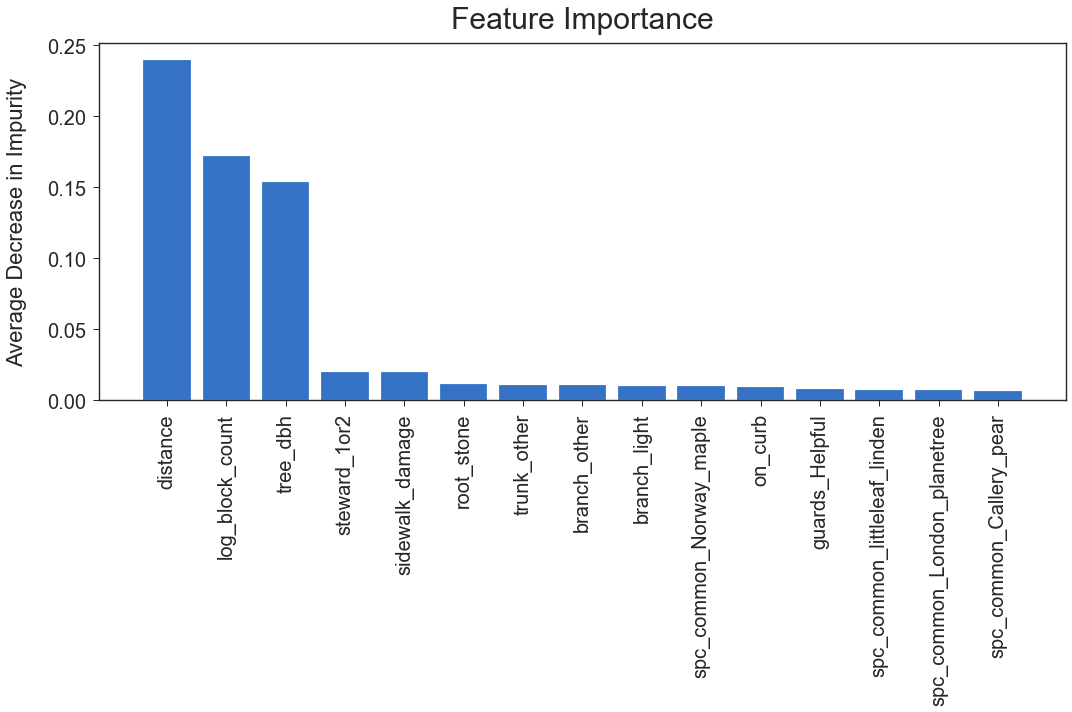

[('distance', 0.23930866415339827), ('log_block_count', 0.17179467068011026), ('tree_dbh', 0.15381908908446754), ('steward_1or2', 0.02014518140691045), ('sidewalk_damage', 0.020033769720354585), ('root_stone', 0.011212088686784546), ('trunk_other', 0.010823745948735046), ('branch_other', 0.01048798448652111), ('branch_light', 0.010320079965674469), ('spc_common_Norway_maple', 0.010144062788068313), ('on_curb', 0.009335541869123243), ('guards_Helpful', 0.007872482275987306), ('spc_common_littleleaf_linden', 0.0071432172903302844), ('spc_common_London_planetree', 0.0071197010792748835), ('spc_common_Callery_pear', 0.006789400272612974)]


In [151]:
# find top-15 feature importance; input model name 
plot_forest_features(forest, X)

Normalized confusion matrix
[[0.27119182 0.7106483  0.01815988]
 [0.0213355  0.97521478 0.00344972]
 [0.10111338 0.6703022  0.22858441]]


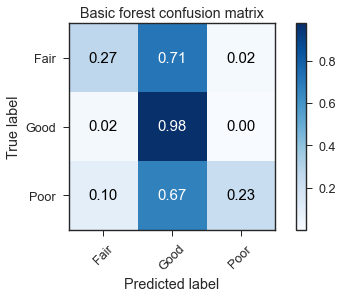

In [152]:
cm = confusion_matrix(y_test, y_pred_forest)
classes = ['Fair', 'Good', 'Poor']

plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Basic forest confusion matrix',
                          cmap=plt.cm.Blues)

### Tuned Random Forest (NO SMOTE) 1

In [153]:
# random forest
forest_tuned = RandomForestClassifier(max_features=11,
                                      min_samples_leaf=3,
                                      class_weight='balanced',
                                      random_state=99, n_jobs=-1,
                                      n_estimators=1000
                                      )

# fit training data
forest_tuned.fit(X_train, y_train)

# predict on test data
y_pred_forest_tuned = forest_tuned.predict(X_test)

# check accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_forest_tuned))
# check f1
print('Test F1 score: ', f1_score(y_test, y_pred_forest_tuned, average='weighted'))
# check recall
print('Test Recall score: ', recall_score(y_test, y_pred_forest_tuned, average='weighted'))
# check precision
print('Test Precision score: ', precision_score(y_test, y_pred_forest_tuned, average='weighted'))

Test Accuracy score:  0.7505576943834779
Test F1 score:  0.7685580438928529
Test Recall score:  0.7505576943834779
Test Precision score:  0.7932633309552292


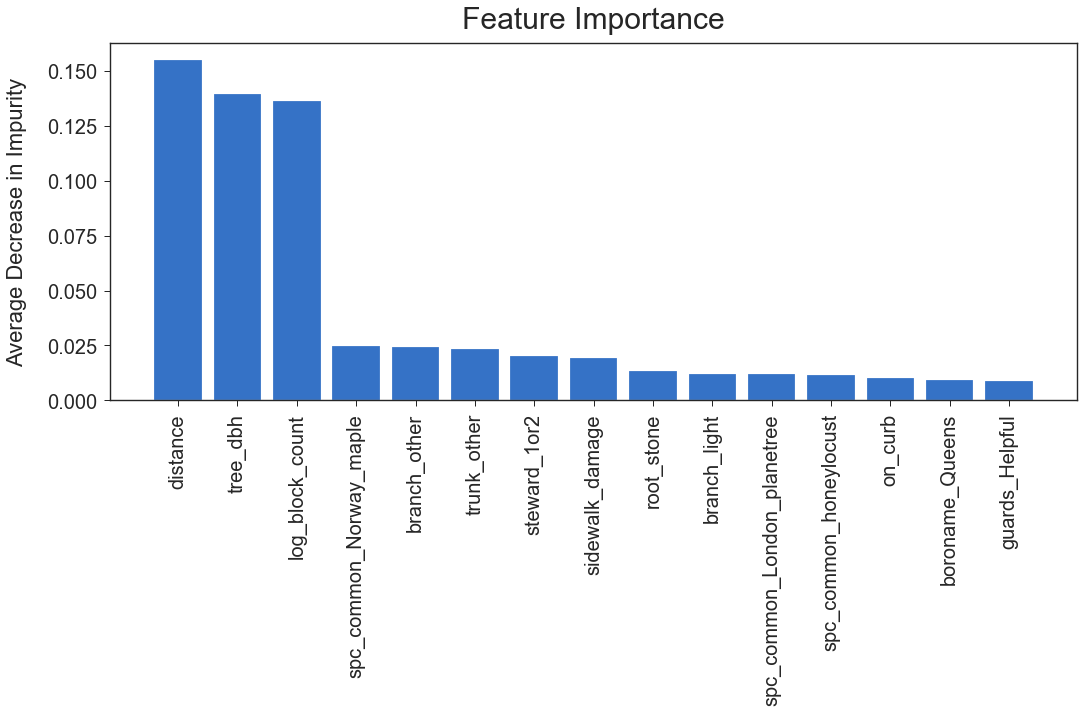

[('distance', 0.15485920131177716), ('tree_dbh', 0.13955923449153063), ('log_block_count', 0.13655399299135237), ('spc_common_Norway_maple', 0.024884571739605368), ('branch_other', 0.024203398722495356), ('trunk_other', 0.02340344352395879), ('steward_1or2', 0.020259363974838875), ('sidewalk_damage', 0.019240977871265212), ('root_stone', 0.013383063362900178), ('branch_light', 0.011965867850616577), ('spc_common_London_planetree', 0.011951042045962765), ('spc_common_honeylocust', 0.011544875464762789), ('on_curb', 0.010262048705144572), ('boroname_Queens', 0.009030466291752335), ('guards_Helpful', 0.008916830700157913)]


In [154]:
plot_forest_features(forest_tuned, X)

Normalized confusion matrix
[[0.41526446 0.45628294 0.1284526 ]
 [0.11959746 0.82258135 0.05782119]
 [0.21245172 0.32674392 0.46080436]]


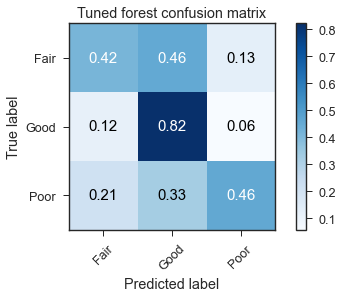

In [156]:
cm_tuned = confusion_matrix(y_test, y_pred_forest_tuned)
classes = ['Fair', 'Good', 'Poor']

plot_confusion_matrix(cm_tuned, classes,
                          normalize=True,
                          title='Tuned forest confusion matrix',
                          cmap=plt.cm.Blues)

### Tuned Random Forest (NO SMOTE) 2

In [157]:
# random forest
forest_tuned = RandomForestClassifier(max_features=11,
                                      min_samples_leaf=3,
                                      class_weight='balanced',
                                      random_state=99, n_jobs=-1,
                                      n_estimators=500
                                      )

# fit training data
forest_tuned.fit(X_train, y_train)

# predict on test data
y_pred_forest_tuned = forest_tuned.predict(X_test)

# check accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_forest_tuned))
# check f1
print('Test F1 score: ', f1_score(y_test, y_pred_forest_tuned, average='weighted'))
# check recall
print('Test Recall score: ', recall_score(y_test, y_pred_forest_tuned, average='weighted'))
# check precision
print('Test Precision score: ', precision_score(y_test, y_pred_forest_tuned, average='weighted'))

Test Accuracy score:  0.7500179901414025
Test F1 score:  0.7682027156696009
Test Recall score:  0.7500179901414025
Test Precision score:  0.7932364914379939


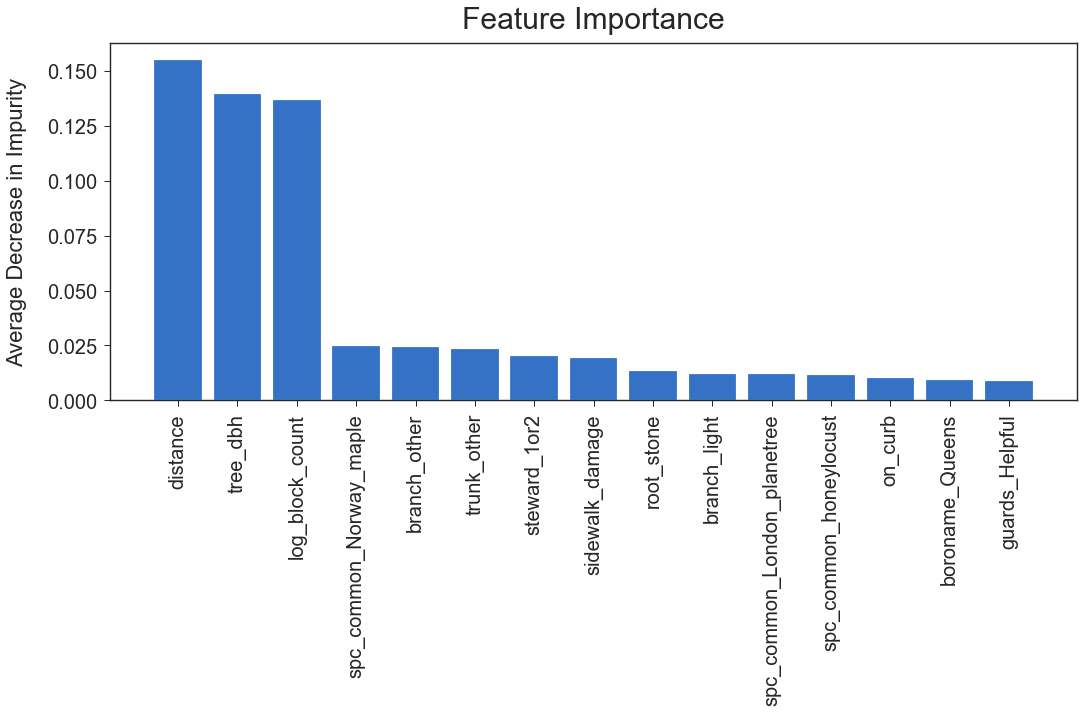

[('distance', 0.15480243832569732), ('tree_dbh', 0.1393170909999476), ('log_block_count', 0.1366807034982776), ('spc_common_Norway_maple', 0.024854269446254733), ('branch_other', 0.024479230441980533), ('trunk_other', 0.02325299290382031), ('steward_1or2', 0.020226743234187324), ('sidewalk_damage', 0.019107389565222444), ('root_stone', 0.01320634104433888), ('branch_light', 0.012013319387207016), ('spc_common_London_planetree', 0.011928986201279487), ('spc_common_honeylocust', 0.011649941479830063), ('on_curb', 0.010247679524600223), ('boroname_Queens', 0.009083587019598547), ('guards_Helpful', 0.008929323481595842)]


In [158]:
plot_forest_features(forest_tuned, X)

Normalized confusion matrix
[[0.41545495 0.4553305  0.12921455]
 [0.1197293  0.82174639 0.05852431]
 [0.20677119 0.32947057 0.46375824]]


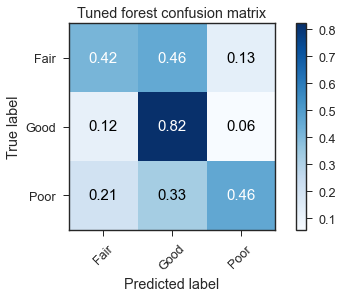

In [159]:
cm_tuned = confusion_matrix(y_test, y_pred_forest_tuned)
classes = ['Fair', 'Good', 'Poor']

plot_confusion_matrix(cm_tuned, classes,
                          normalize=True,
                          title='Tuned forest confusion matrix',
                          cmap=plt.cm.Blues)

### Tuned Random Forest (NO SMOTE) 3

In [160]:
# random forest
forest_tuned = RandomForestClassifier(max_features=11,
                                      min_samples_leaf=3,
                                      class_weight='balanced',
                                      random_state=99, n_jobs=-1,
                                      n_estimators=100
                                      )

# fit training data
forest_tuned.fit(X_train, y_train)

# predict on test data
y_pred_forest_tuned = forest_tuned.predict(X_test)

# check accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_forest_tuned))
# check f1
print('Test F1 score: ', f1_score(y_test, y_pred_forest_tuned, average='weighted'))
# check recall
print('Test Recall score: ', recall_score(y_test, y_pred_forest_tuned, average='weighted'))
# check precision
print('Test Precision score: ', precision_score(y_test, y_pred_forest_tuned, average='weighted'))

Test Accuracy score:  0.7459792033965387
Test F1 score:  0.7650279078473252
Test Recall score:  0.7459792033965387
Test Precision score:  0.7912224307995114


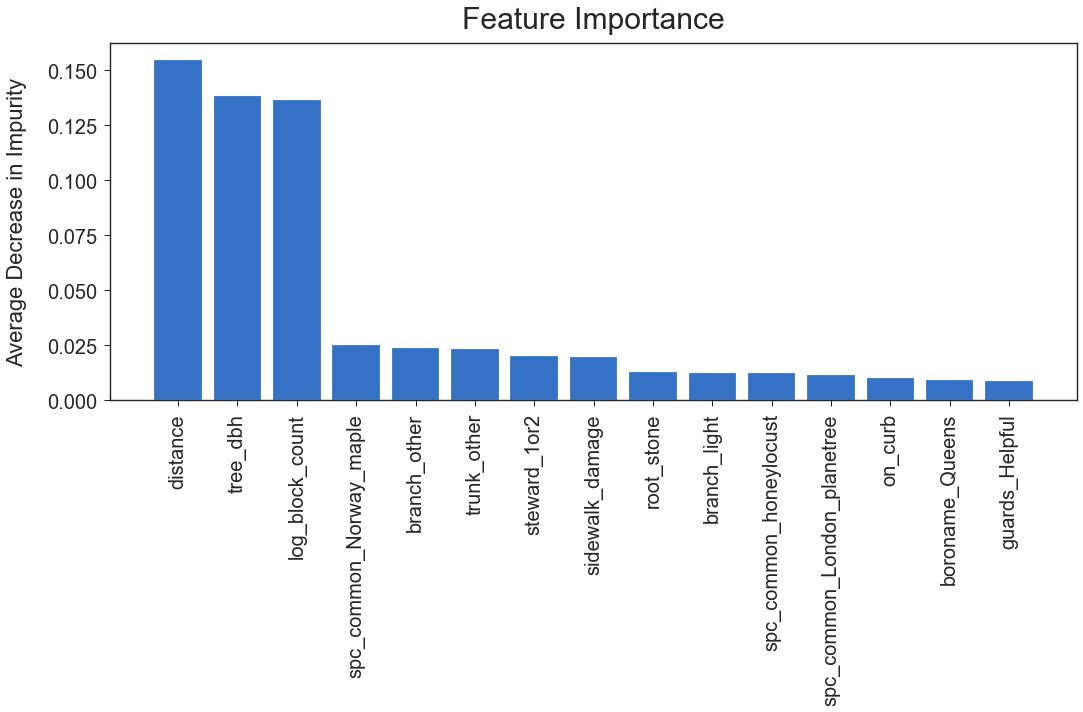

[('distance', 0.15448138879248818), ('tree_dbh', 0.13846811517647428), ('log_block_count', 0.1362981299794262), ('spc_common_Norway_maple', 0.02495503918710912), ('branch_other', 0.0235787665147912), ('trunk_other', 0.02351044969919089), ('steward_1or2', 0.020040346484651674), ('sidewalk_damage', 0.019770194823714084), ('root_stone', 0.01269561152449516), ('branch_light', 0.012416815781566766), ('spc_common_honeylocust', 0.01221728701818552), ('spc_common_London_planetree', 0.011689171182882575), ('on_curb', 0.010196313728437625), ('boroname_Queens', 0.00937256135376302), ('guards_Helpful', 0.008905970900847349)]


In [161]:
plot_forest_features(forest_tuned, X)

Normalized confusion matrix
[[0.41335958 0.45552099 0.13111944]
 [0.1230252  0.81774736 0.05922744]
 [0.20949784 0.33855942 0.45194274]]


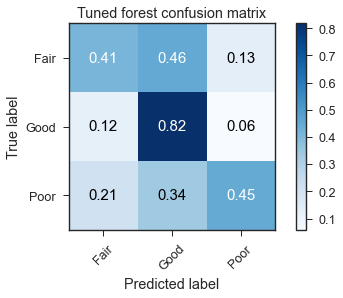

In [162]:
cm_tuned = confusion_matrix(y_test, y_pred_forest_tuned)
classes = ['Fair', 'Good', 'Poor']

plot_confusion_matrix(cm_tuned, classes,
                          normalize=True,
                          title='Tuned forest confusion matrix',
                          cmap=plt.cm.Blues)

### Tuned Random Forest (NO SMOTE) 4

In [153]:
# random forest
forest_tuned = RandomForestClassifier(max_features=11,
                                      min_samples_leaf=3,
                                      class_weight='balanced',
                                      random_state=99, n_jobs=-1,
                                      n_estimators=1000
                                      )

# fit training data
forest_tuned.fit(X_train, y_train)

# predict on test data
y_pred_forest_tuned = forest_tuned.predict(X_test)

# check accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_forest_tuned))
# check f1
print('Test F1 score: ', f1_score(y_test, y_pred_forest_tuned, average='weighted'))
# check recall
print('Test Recall score: ', recall_score(y_test, y_pred_forest_tuned, average='weighted'))
# check precision
print('Test Precision score: ', precision_score(y_test, y_pred_forest_tuned, average='weighted'))

Test Accuracy score:  0.7505576943834779
Test F1 score:  0.7685580438928529
Test Recall score:  0.7505576943834779
Test Precision score:  0.7932633309552292


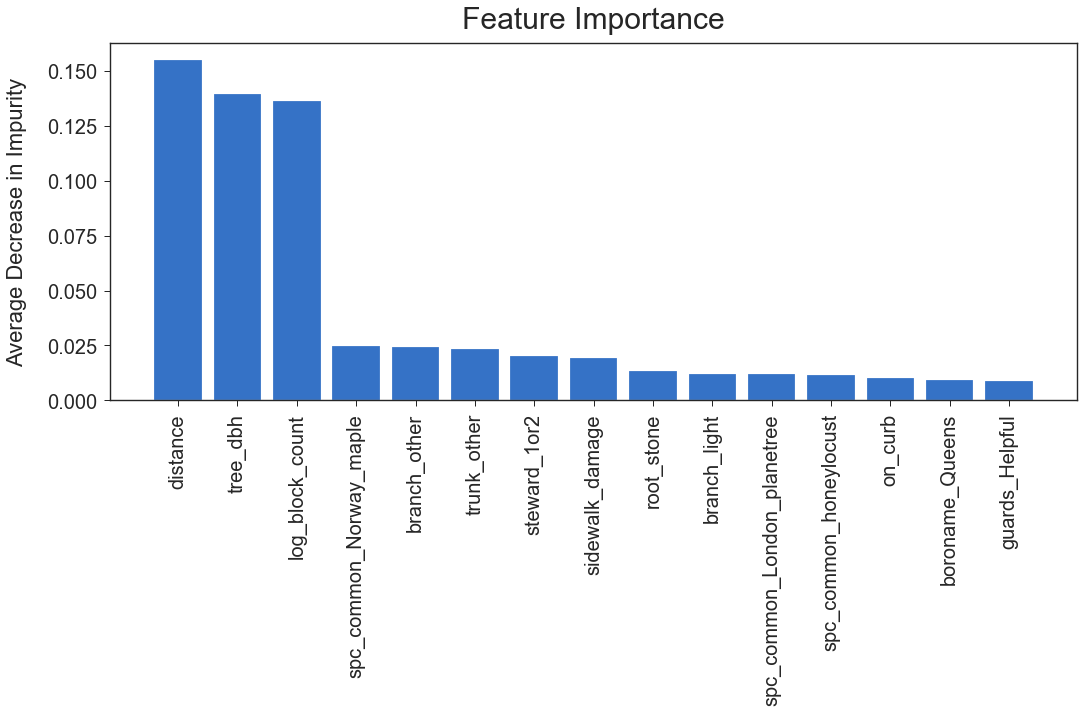

[('distance', 0.15485920131177716), ('tree_dbh', 0.13955923449153063), ('log_block_count', 0.13655399299135237), ('spc_common_Norway_maple', 0.024884571739605368), ('branch_other', 0.024203398722495356), ('trunk_other', 0.02340344352395879), ('steward_1or2', 0.020259363974838875), ('sidewalk_damage', 0.019240977871265212), ('root_stone', 0.013383063362900178), ('branch_light', 0.011965867850616577), ('spc_common_London_planetree', 0.011951042045962765), ('spc_common_honeylocust', 0.011544875464762789), ('on_curb', 0.010262048705144572), ('boroname_Queens', 0.009030466291752335), ('guards_Helpful', 0.008916830700157913)]


In [154]:
plot_forest_features(forest_tuned, X)

Normalized confusion matrix
[[0.41526446 0.45628294 0.1284526 ]
 [0.11959746 0.82258135 0.05782119]
 [0.21245172 0.32674392 0.46080436]]


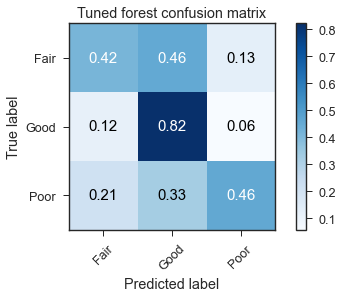

In [156]:
cm_tuned = confusion_matrix(y_test, y_pred_forest_tuned)
classes = ['Fair', 'Good', 'Poor']

plot_confusion_matrix(cm_tuned, classes,
                          normalize=True,
                          title='Tuned forest confusion matrix',
                          cmap=plt.cm.Blues)

### Tuned Random Forest (NO SMOTE) 5

In [153]:
# random forest
forest_tuned = RandomForestClassifier(max_features=11,
                                      min_samples_leaf=3,
                                      class_weight='balanced',
                                      random_state=99, n_jobs=-1,
                                      n_estimators=1000
                                      )

# fit training data
forest_tuned.fit(X_train, y_train)

# predict on test data
y_pred_forest_tuned = forest_tuned.predict(X_test)

# check accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_forest_tuned))
# check f1
print('Test F1 score: ', f1_score(y_test, y_pred_forest_tuned, average='weighted'))
# check recall
print('Test Recall score: ', recall_score(y_test, y_pred_forest_tuned, average='weighted'))
# check precision
print('Test Precision score: ', precision_score(y_test, y_pred_forest_tuned, average='weighted'))

Test Accuracy score:  0.7505576943834779
Test F1 score:  0.7685580438928529
Test Recall score:  0.7505576943834779
Test Precision score:  0.7932633309552292


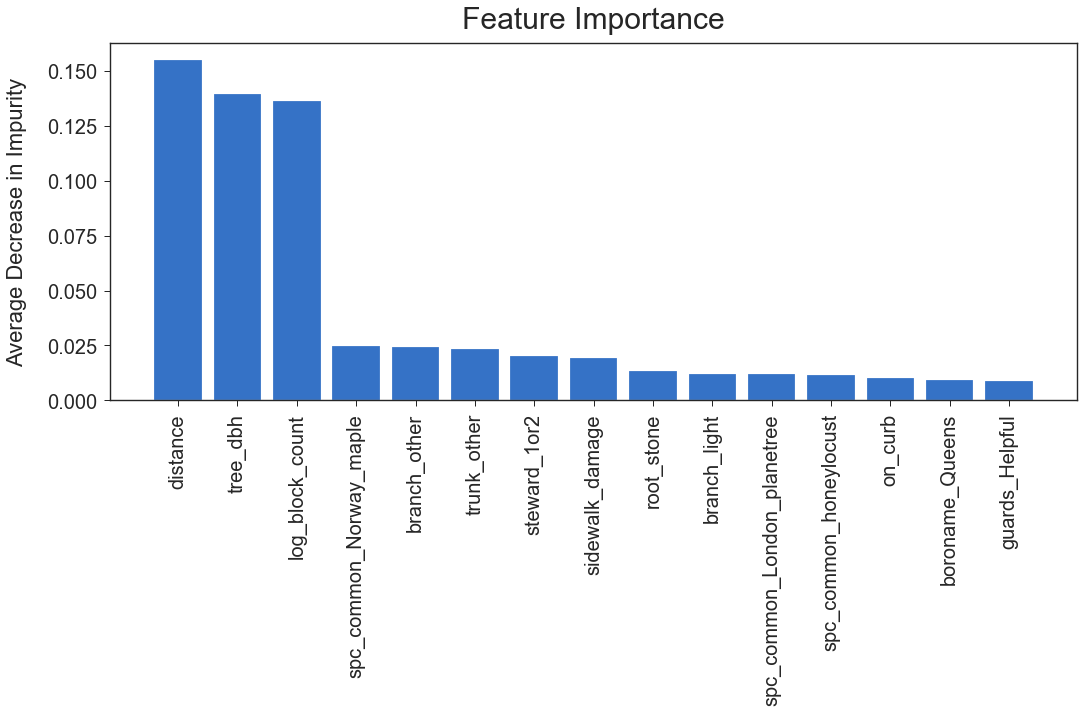

[('distance', 0.15485920131177716), ('tree_dbh', 0.13955923449153063), ('log_block_count', 0.13655399299135237), ('spc_common_Norway_maple', 0.024884571739605368), ('branch_other', 0.024203398722495356), ('trunk_other', 0.02340344352395879), ('steward_1or2', 0.020259363974838875), ('sidewalk_damage', 0.019240977871265212), ('root_stone', 0.013383063362900178), ('branch_light', 0.011965867850616577), ('spc_common_London_planetree', 0.011951042045962765), ('spc_common_honeylocust', 0.011544875464762789), ('on_curb', 0.010262048705144572), ('boroname_Queens', 0.009030466291752335), ('guards_Helpful', 0.008916830700157913)]


In [154]:
plot_forest_features(forest_tuned, X)

Normalized confusion matrix
[[0.41526446 0.45628294 0.1284526 ]
 [0.11959746 0.82258135 0.05782119]
 [0.21245172 0.32674392 0.46080436]]


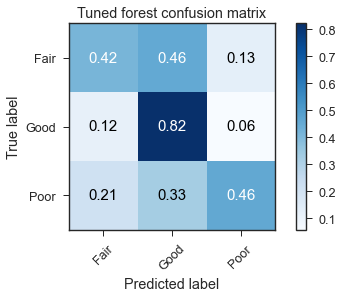

In [156]:
cm_tuned = confusion_matrix(y_test, y_pred_forest_tuned)
classes = ['Fair', 'Good', 'Poor']

plot_confusion_matrix(cm_tuned, classes,
                          normalize=True,
                          title='Tuned forest confusion matrix',
                          cmap=plt.cm.Blues)

In [ ]:
# create a params dictionary for Random Forest
params_forest = {
    'max_features': range(5,12,2),
    'min_samples_leaf': range(1,6),
    'n_estimators': 100
}

In [164]:
random_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [100, 250, 500, 1000]
}

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(class_weight='balanced', random_state=99)
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, cv=5,
                               verbose=2, random_state=42, n_jobs=-1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 57.6min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 482.4min


In [ ]:
# examine the best model

# Single best score achieved across all params (min_samples_split)
print(rf_random.best_score_)

# Dictionary containing the parameters (min_samples_split) used to generate that score
print(rf_random.best_params_)

# Actual model object fit with those best parameters
# Shows default parameters that we did not specify
print(rf_random.best_estimator_)

In [ ]:
# predict on test data using best model
y_pred_rf_random = rf_random.best_estimator_.predict(X_test)

# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_rf_random))

# checking f1
print('Test F1 score: ', f1_score(y_test, y_pred_rf_random, average='weighted'))

# checking recall
print('Test Recall score: ', recall_score(y_test, y_pred_rf_random, average='weighted'))

# checking precision
print('Test Precision score: ', precision_score(y_test, y_pred_rf_random, average='weighted'))

In [ ]:
cm_random = confusion_matrix(y_test, y_pred_rf_random)
classes = ['Fair', 'Good', 'Poor']

plot_confusion_matrix(cm_random, classes,
                          normalize=True,
                          title='Randomly tuned forest confusion matrix',
                          cmap=plt.cm.Blues)

In [ ]:
# create a grid search object and fit it to the data
forest_cv = RandomForestClassifier(class_weight='balanced', random_state=99, n_jobs=-1)
CV_forest = GridSearchCV(forest_cv, params_forest, scoring='f1_weighted', n_jobs=-1, verbose=2)

In [ ]:
CV_bnb.fit(X_train_smote, y_train_smote)

### Smote

In [ ]:
smoten = SMOTE(sampling_strategy='minority', random_state=42)
X_train_smote, y_train_smote = smoten.fit_sample(X_train, y_train)

### Random Forest - basic

In [ ]:
# random forest
forest_smote = RandomForestClassifier(
#                                         class_weight='balanced',
                                        random_state=99, n_jobs=-1)

# fit training data
forest_smote.fit(X_train_smote, y_train_smote)

# predict on test data
y_pred_forest_smote = forest_smote.predict(X_test)

# check accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_forest_smote))
# check f1
print('Test F1 score: ', f1_score(y_test, y_pred_forest_smote, average='weighted'))
# check recall
print('Test Recall score: ', recall_score(y_test, y_pred_forest_smote, average='weighted'))
# check precision
print('Test Precision score: ', precision_score(y_test, y_pred_forest_smote, average='weighted'))

In [ ]:
plot_forest_features(forest_smote, X)

In [ ]:
cm_smote = confusion_matrix(y_test, y_pred_forest_smote)
classes = ['Fair', 'Good', 'Poor']

plot_confusion_matrix(cm_smote, classes,
                          normalize=True,
                          title='Untuned forest confusion matrix',
                          cmap=plt.cm.Blues)

### Random Forest - tuned

In [ ]:
# random forest
forest_smote_tuned = RandomForestClassifier(max_features=11,
                                       min_samples_leaf=3,
                                        class_weight='balanced',
                                        random_state=99, n_jobs=-1,
                                      n_estimators=1000
                                      )

# fit training data
forest_smote_tuned.fit(X_train_smote, y_train_smote)

# predict on test data
y_pred_forest_smote_tuned = forest_smote_tuned.predict(X_test)

# check accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_forest_smote_tuned))
# check f1
print('Test F1 score: ', f1_score(y_test, y_pred_forest_smote_tuned, average='weighted'))
# check recall
print('Test Recall score: ', recall_score(y_test, y_pred_forest_smote_tuned, average='weighted'))
# check precision
print('Test Precision score: ', precision_score(y_test, y_pred_forest_smote_tuned, average='weighted'))

In [ ]:
plot_forest_features(forest_smote_tuned, X)

In [ ]:
cm_smote_tuned = confusion_matrix(y_test, y_pred_forest_smote_tuned)
classes = ['Fair', 'Good', 'Poor']

plot_confusion_matrix(cm_smote_tuned, classes,
                          normalize=True,
                          title='Tuned forest confusion matrix',
                          cmap=plt.cm.Blues)

* Pickle it (it's huge).

In [ ]:
with gzip.open('data/final_model.pickle', 'wb') as f:
    pickle.dump(forest_smote_tuned, f, protocol=pickle.HIGHEST_PROTOCOL)

### Naive Bayes - Gaussian

In [ ]:
# create Gaussian Naive Bayes object with prior probabilities of each class
gnb = GaussianNB(priors=[0.14, 0.82, 0.04],
#                  var_smoothing=.25
                )

# train model
ganaba = gnb.fit(X_train_smote, y_train_smote)

# predict on test data
y_pred_gnb = ganaba.predict(X_test)

# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_gnb))

# checking f1
print('Test F1 score: ', f1_score(y_test, y_pred_gnb, average='weighted'))

# checking recall
print('Test Recall score: ', recall_score(y_test, y_pred_gnb, average='weighted'))

# checking precision
print('Test Precision score: ', precision_score(y_test, y_pred_gnb, average='weighted'))

In [ ]:
cm_gnb = confusion_matrix(y_test, y_pred_gnb)
classes = ['Fair', 'Good', 'Poor']

plot_confusion_matrix(cm_gnb, classes,
                          normalize=True,
                          title='Gaussian confusion matrix',
                          cmap=plt.cm.Blues)

### Naive Bayes - Bernoulli

In [ ]:
# Create Bernoulli Naive Bayes object with prior probabilities of each class
bnb = BernoulliNB(class_prior=[0.175, 0.75, 0.075])

# Train model
banaba = bnb.fit(X_train_smote, y_train_smote)

# predict on test data
y_pred_bnb = banaba.predict(X_test)

# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_bnb))

# checking f1
print('Test F1 score: ', f1_score(y_test, y_pred_bnb, average='weighted'))

# checking recall
print('Test Recall score: ', recall_score(y_test, y_pred_bnb, average='weighted'))

# checking precision
print('Test Precision score: ', precision_score(y_test, y_pred_bnb, average='weighted'))

In [ ]:
cm_bnb = confusion_matrix(y_test, y_pred_bnb)
classes = ['Fair', 'Good', 'Poor']

plot_confusion_matrix(cm_bnb, classes,
                          normalize=True,
                          title='Bernoulli confusion matrix',
                          cmap=plt.cm.Blues)

In [ ]:
# Create a params dictionary for a Bernoulli Naive Bayes classifier with prior probabilities of each class
params_nb = {
    'class_prior': [[0.1, 0.88, 0.02],[0.14, 0.82, 0.04], [0.175, 0.75, 0.075], [0.2, 0.7, 0.1]],
    'alpha': [.00001*10**i for i in range(5)],
}

### Naive Bayes - Bernoulli (with GridSearch)

In [ ]:
#create a grid search object and fit it to the data
bnb_cv = BernoulliNB()
CV_bnb = GridSearchCV(bnb_cv, params_nb, scoring='f1_weighted', n_jobs=-1, verbose=2)
CV_bnb.fit(X_train_smote, y_train_smote)

In [ ]:
# examine the best model

# Single best score achieved across all params (min_samples_split)
print(CV_bnb.best_score_)

# Dictionary containing the parameters (min_samples_split) used to generate that score
print(CV_bnb.best_params_)

# Actual model object fit with those best parameters
# Shows default parameters that we did not specify
print(CV_bnb.best_estimator_)

In [ ]:
# predict on test data using best model
y_pred_bnb_cv = CV_bnb.best_estimator_.predict(X_test)

# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_bnb_cv))

# checking f1
print('Test F1 score: ', f1_score(y_test, y_pred_bnb_cv, average='weighted'))

# checking recall
print('Test Recall score: ', recall_score(y_test, y_pred_bnb_cv, average='weighted'))

# checking precision
print('Test Precision score: ', precision_score(y_test, y_pred_bnb_cv, average='weighted'))

In [ ]:
cm5 = confusion_matrix(y_test, y_pred_bnb_cv)
classes = ['Fair', 'Good', 'Poor']

plot_confusion_matrix(cm5, classes,
                          normalize=True,
                          title='Bernoulli confusion matrix',
                          cmap=plt.cm.Blues)

## Findings
* Species of tree is significant, Norway maple being the least good on average, and sawtooth oak being the most good.
    * I would recommend sticking to the healthier varieties in the graph created earlier, and avoiding the least healthy varieties.
* Problems with the tree itself were obviously significant.
    * Unfortunately, problems that were listed as “other” appear to hold the highest significance. In the next census, they should include columns with more specificity or a notes column (which one could feasibly process to create dummy variables).
    * I suggest conducting more regular maintenance, as well as pushing for environmental protections, in the style of the plastic ban bag.
* All levels of neighborhood delineation held significance.
    * I chose community board as my neighborhood variable in part because one must petition the community board to make changes to street trees.
* It's difficult to choose which model to use based off numbers alone. One must think carefully about how it is being used.
    * I went with a model that was more inaccurate but had a better spread of predictions. Not ready for primetime yet, but a step in the right direction.
* Many of the most prevalent features, including number of trees on block, distance to the nearest tree, and sidewalk damage, didn’t show much significance when looked at during EDA, but must have had solid predictive power after interacting with other branches of the Random Forest trees.

## Most prevalent features in the model (in order)
### Top features (out of 147):
     Tree diameter 			    (14.8%)
     Number of trees on block 	(11.2%)
     Distance to nearest tree 	(9.1%)
     Sidewalk damage 		    (7.6%)
     Tree stewards [1-2] 		(5.1%)
     Root problems [stone]      (4.8%)
     Species [Norway maple] 	(2.6%)
     Trunk problems [other] 	(2.4%)
     Branch problems [light] 	(2.2%)
     Species [London planetree] (2.0%)
     Branch problems [other] 	(2.0%)
     Community board [503] 	    (1.8%)
     Species [Honeylocust] 	    (1.3%)
     Borough [Queens] 		    (1.2%)



# Final conclusion
* I can run my final model on the data collected by volunteers and compile a list of trees that whose health statuses do not line up. In the meantime, the NYC Street Trees Census is fairly thorough and rife with opportunities for data exploration and predictive modeling. Perhaps with a neural network, I could greatly improve my model. In future censuses, even more data could be gathered (especially in regard to specificity) that will increase these opportunities for prediction even further.